# Model 1: Vanilla CNN (5 Layers)

---

**Architecture**
- 5-layer Convolutional Neural Network
- Dual-head output: Pitch + Roll classification
- Shared backbone for feature extraction

**Hardware:** Apple M4 + 24GB Unified Memory (MPS)


## 1. Setup & Data Loading

In [38]:
# Standard libraries
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Optuna for hyperparameter tuning
import optuna

# Visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project modules
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# Import dataset
from src.data.pose_dataset import ClassificationDataset

# Import shared utilities (Relevant conde in src/utils.py)
from src.utils import (
    # Training
    MetricsTracker,
    train_epoch,
    validate_epoch,
    collect_predictions,
    EarlyStopping,
    # Data
    create_stratified_splits,
    create_dataloaders,
    get_class_mappings,
    # Visualization
     plot_training_curves,
    plot_confusion_matrices,
    plot_per_class_performance,
    plot_optuna_results,
    plot_feature_maps,
    plot_grad_cam,
    plot_embedding_tsne,
    # Evaluation
    compute_metrics,
    compute_computational_cost,
    print_model_summary,
    generate_classification_report
)

# Set device
# Determine the device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
import numpy as np
np.random.seed(42)

print("All libraries and utilities imported successfully")

Using device: mps
All libraries and utilities imported successfully


### Load Dataset & Create Splits

In [2]:
# Load full dataset
data_root = project_root / 'data'
full_dataset = ClassificationDataset(rootpath=str(data_root), augment=False)

print(f"Total samples: {len(full_dataset)}")
print(f"Pitch classes: {len(full_dataset.p_dict)}")
print(f"Roll classes: {len(full_dataset.r_dict)}")
print(f"\nPitch mapping: {full_dataset.p_dict}")
print(f"Roll mapping: {full_dataset.r_dict}")

Total samples: 2000
Pitch classes: 18
Roll classes: 7

Pitch mapping: {'P0': 0, 'P10': 1, 'P15': 2, 'P25': 3, 'P30': 4, 'P35': 5, 'P40': 6, 'P45': 7, 'P50': 8, 'P55': 9, 'P5': 10, 'P60': 11, 'P65': 12, 'P70': 13, 'P75': 14, 'P80': 15, 'P85': 16, 'P90': 17}
Roll mapping: {'R0': 0, 'R15': 1, 'R30': 2, 'R45': 3, 'R5': 4, 'R10': 5, 'R60': 6}


In [3]:
# Use utility function for stratified splits (REPLACES manual split code)
train_idx, val_idx, test_idx = create_stratified_splits(
    dataset=full_dataset,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    random_state=42
)

print(f"\nSplit sizes:")
print(f"   Train: {len(train_idx)} ({len(train_idx)/len(full_dataset)*100:.1f}%)")
print(f"   Val:   {len(val_idx)} ({len(val_idx)/len(full_dataset)*100:.1f}%)")
print(f"   Test:  {len(test_idx)} ({len(test_idx)/len(full_dataset)*100:.1f}%)")


Split sizes:
   Train: 1200 (60.0%)
   Val:   400 (20.0%)
   Test:  400 (20.0%)


In [20]:
# Create dataset splits with augmentation for training
train_dataset = ClassificationDataset(rootpath=str(data_root), augment=True, random_ratio=0.5)
val_dataset = ClassificationDataset(rootpath=str(data_root), augment=False)
test_dataset = ClassificationDataset(rootpath=str(data_root), augment=False)

# Use utility function for dataloader creation (REPLACES manual DataLoader code)
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    train_indices=train_idx,
    val_indices=val_idx,
    test_indices=test_idx,
    batch_size=64,
    num_workers=0,  # MPS-optimized
    pin_memory=False  # MPS-optimized
)

# Get class mappings (NEW utility function)
mappings = get_class_mappings(full_dataset)

print("Datasets and loaders created")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")
print(f"   Pitch classes: {mappings['num_pitch_classes']}")
print(f"   Roll classes: {mappings['num_roll_classes']}")

Datasets and loaders created
   Train batches: 19
   Val batches: 7
   Test batches: 7
   Pitch classes: 18
   Roll classes: 7


## 2. Model Architecture

**Vanilla CNN Design:**
- 5 convolutional layers with increasing channels
- MaxPooling for downsampling
- Batch normalization for stability
- Dropout for regularization
- Dual classification heads (pitch + roll)

In [5]:
class VanillaCNN(nn.Module):
    """
    5-layer Vanilla CNN for dual-head pose classification
    
    Args:
        num_pitch_classes: Number of pitch angle classes
        num_roll_classes: Number of roll angle classes
        channels: List of channel sizes for each conv layer
        fc_dim: Fully connected layer dimension
        dropout_rate: Dropout probability
        use_bn: Use batch normalization
    """
    
    def __init__(
        self,
        num_pitch_classes=18,
        num_roll_classes=7,
        channels=[32, 64, 128, 256, 512],
        fc_dim=256,
        dropout_rate=0.3,
        use_bn=True
    ):
        super(VanillaCNN, self).__init__()
        
        self.use_bn = use_bn
        
        # Feature extraction backbone (5 conv blocks)
        self.features = nn.ModuleList()
        
        in_channels = 3
        for out_channels in channels:
            block = []
            block.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if use_bn:
                block.append(nn.BatchNorm2d(out_channels))
            block.append(nn.ReLU(inplace=True))
            block.append(nn.MaxPool2d(2, 2))
            
            self.features.append(nn.Sequential(*block))
            in_channels = out_channels
        
        # Adaptive pooling to handle variable spatial sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Shared fully connected layer
        self.fc_shared = nn.Sequential(
            nn.Linear(channels[-1], fc_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )
        
        # Pitch classification head
        self.pitch_head = nn.Linear(fc_dim, num_pitch_classes)
        
        # Roll classification head
        self.roll_head = nn.Linear(fc_dim, num_roll_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x, return_features=False):
        # Feature extraction
        for block in self.features:
            x = block(x)
        
        # Global average pooling
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        
        # Shared features
        features = self.fc_shared(x)
        
        # Dual heads
        pitch_out = self.pitch_head(features)
        roll_out = self.roll_head(features)
        
        if return_features:
            return pitch_out, roll_out, features
        return pitch_out, roll_out
    
    def get_num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Test model
test_model = VanillaCNN()
test_input = torch.randn(1, 3, 224, 224)
pitch_out, roll_out = test_model(test_input)

print(f"Model architecture defined")
print(f"   Input shape: {test_input.shape}")
print(f"   Pitch output: {pitch_out.shape}")
print(f"   Roll output: {roll_out.shape}")
print(f"   Total parameters: {test_model.get_num_params():,}")

Model architecture defined
   Input shape: torch.Size([1, 3, 224, 224])
   Pitch output: torch.Size([1, 18])
   Roll output: torch.Size([1, 7])
   Total parameters: 1,708,313


## 3. Training (Baseline)

First training run with default hyperparameters to establish baseline performance.

In [6]:
print("Just to remember: Training utilities ready (imported from src.utils)")

print("   - MetricsTracker: Track metrics across epochs")
print("   - train_epoch(): Train for one epoch")
print("   - validate_epoch(): Validate for one epoch")
print("   - EarlyStopping: Prevent overfitting")
print("   - collect_predictions(): Get all predictions")

Just to remember: Training utilities ready (imported from src.utils)
   - MetricsTracker: Track metrics across epochs
   - train_epoch(): Train for one epoch
   - validate_epoch(): Validate for one epoch
   - EarlyStopping: Prevent overfitting
   - collect_predictions(): Get all predictions


In [7]:
# Baseline hyperparameters
BASELINE_CONFIG = {
    'batch_size': 64,
    'lr': 1e-3,
    'epochs': 100,
    'channels': [32, 64, 128, 256, 512],
    'fc_dim': 256,
    'dropout_rate': 0.3,
    'use_bn': True,
    'weight_decay': 1e-4
}

# Data loaders already created using create_dataloaders() utility in cell-6!
# No need to create them again here

print(f"Baseline configuration set")
print(f"   Batch size: {BASELINE_CONFIG['batch_size']}")
print(f"   Learning rate: {BASELINE_CONFIG['lr']}")
print(f"   Epochs: {BASELINE_CONFIG['epochs']}")

Baseline configuration set
   Batch size: 64
   Learning rate: 0.001
   Epochs: 100


In [8]:
# Initialize baseline model
baseline_model = VanillaCNN(
    num_pitch_classes=len(full_dataset.p_dict),
    num_roll_classes=len(full_dataset.r_dict),
    channels=BASELINE_CONFIG['channels'],
    fc_dim=BASELINE_CONFIG['fc_dim'],
    dropout_rate=BASELINE_CONFIG['dropout_rate'],
    use_bn=BASELINE_CONFIG['use_bn']
).to(device)

# Loss functions
criterion_pitch = nn.CrossEntropyLoss()
criterion_roll = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(
    baseline_model.parameters(),
    lr=BASELINE_CONFIG['lr'],
    weight_decay=BASELINE_CONFIG['weight_decay']
)

# Learning rate scheduler
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Metrics tracker
baseline_tracker = MetricsTracker()

print(f"Baseline model initialized")
print(f"   Parameters: {baseline_model.get_num_params():,}")
print(f"   Device: {device}")

Baseline model initialized
   Parameters: 1,708,313
   Device: mps


### Training

In [ ]:
# Training loop
print("Baseline training\n")

best_val_acc = 0
patience = 20
patience_counter = 0

for epoch in range(1, BASELINE_CONFIG['epochs'] + 1):
    # Train
    train_metrics = train_epoch(
        baseline_model, train_loader,
        criterion_pitch, criterion_roll,
        optimizer, device
    )
    
    # Validate
    val_metrics = validate_epoch(
        baseline_model, val_loader,
        criterion_pitch, criterion_roll,
        device
    )
    
    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Track metrics
    baseline_tracker.update({
        'train_loss': train_metrics['loss'],
        'train_pitch_loss': train_metrics['pitch_loss'],
        'train_roll_loss': train_metrics['roll_loss'],
        'train_pitch_acc': train_metrics['pitch_acc'],
        'train_roll_acc': train_metrics['roll_acc'],
        'val_loss': val_metrics['loss'],
        'val_pitch_loss': val_metrics['pitch_loss'],
        'val_roll_loss': val_metrics['roll_loss'],
        'val_pitch_acc': val_metrics['pitch_acc'],
        'val_roll_acc': val_metrics['roll_acc'],
        'lr': current_lr
    })
    
    # Save best model
    val_acc_avg = (val_metrics['pitch_acc'] + val_metrics['roll_acc']) / 2
    if val_acc_avg > best_val_acc:
        best_val_acc = val_acc_avg
        torch.save(baseline_model.state_dict(), project_root / 'models' / '1_vanilla_cnn_baseline_best.pth')
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Print progress
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}/{BASELINE_CONFIG['epochs']}")
        print(f"  Train - Loss: {train_metrics['loss']:.4f} | "
              f"Pitch Acc: {train_metrics['pitch_acc']:.3f} | "
              f"Roll Acc: {train_metrics['roll_acc']:.3f}")
        print(f"  Val   - Loss: {val_metrics['loss']:.4f} | "
              f"Pitch Acc: {val_metrics['pitch_acc']:.3f} | "
              f"Roll Acc: {val_metrics['roll_acc']:.3f}")
        print(f"  LR: {current_lr:.6f}\n")
    
    # Early stopping
    if patience_counter >= patience:
        print(f" Early stopping triggered at epoch {epoch}")
        break

print(f"\n Baseline training completed")
print(f"   Best validation accuracy: {best_val_acc:.4f}")

Baseline training

Epoch 01/100
  Train - Loss: 4.2401 | Pitch Acc: 0.162 | Roll Acc: 0.432
  Val   - Loss: 4.3473 | Pitch Acc: 0.172 | Roll Acc: 0.450
  LR: 0.000976

Epoch 05/100
  Train - Loss: 3.3671 | Pitch Acc: 0.163 | Roll Acc: 0.527
  Val   - Loss: 3.5034 | Pitch Acc: 0.172 | Roll Acc: 0.510
  LR: 0.000500

Epoch 10/100
  Train - Loss: 2.9739 | Pitch Acc: 0.201 | Roll Acc: 0.596
  Val   - Loss: 2.8459 | Pitch Acc: 0.212 | Roll Acc: 0.667
  LR: 0.001000

Epoch 15/100
  Train - Loss: 2.6807 | Pitch Acc: 0.218 | Roll Acc: 0.661
  Val   - Loss: 2.4424 | Pitch Acc: 0.265 | Roll Acc: 0.710
  LR: 0.000854

Epoch 20/100
  Train - Loss: 2.2087 | Pitch Acc: 0.280 | Roll Acc: 0.782
  Val   - Loss: 2.0480 | Pitch Acc: 0.310 | Roll Acc: 0.810
  LR: 0.000500

Epoch 25/100
  Train - Loss: 1.8919 | Pitch Acc: 0.377 | Roll Acc: 0.855
  Val   - Loss: 1.7915 | Pitch Acc: 0.495 | Roll Acc: 0.830
  LR: 0.000146

Epoch 30/100
  Train - Loss: 1.7968 | Pitch Acc: 0.424 | Roll Acc: 0.861
  Val   - Loss

In [ ]:
baseline_model.load_state_dict(torch.load(project_root / 'models' / '1_vanilla_cnn_baseline_best.pth'))
baseline_model.eval()

VanillaCNN(
  (features): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (

## 4. Evaluation & Error Analysis

Comprehensive analysis of baseline model performance.

### 4.1 Training Dynamics Visualization

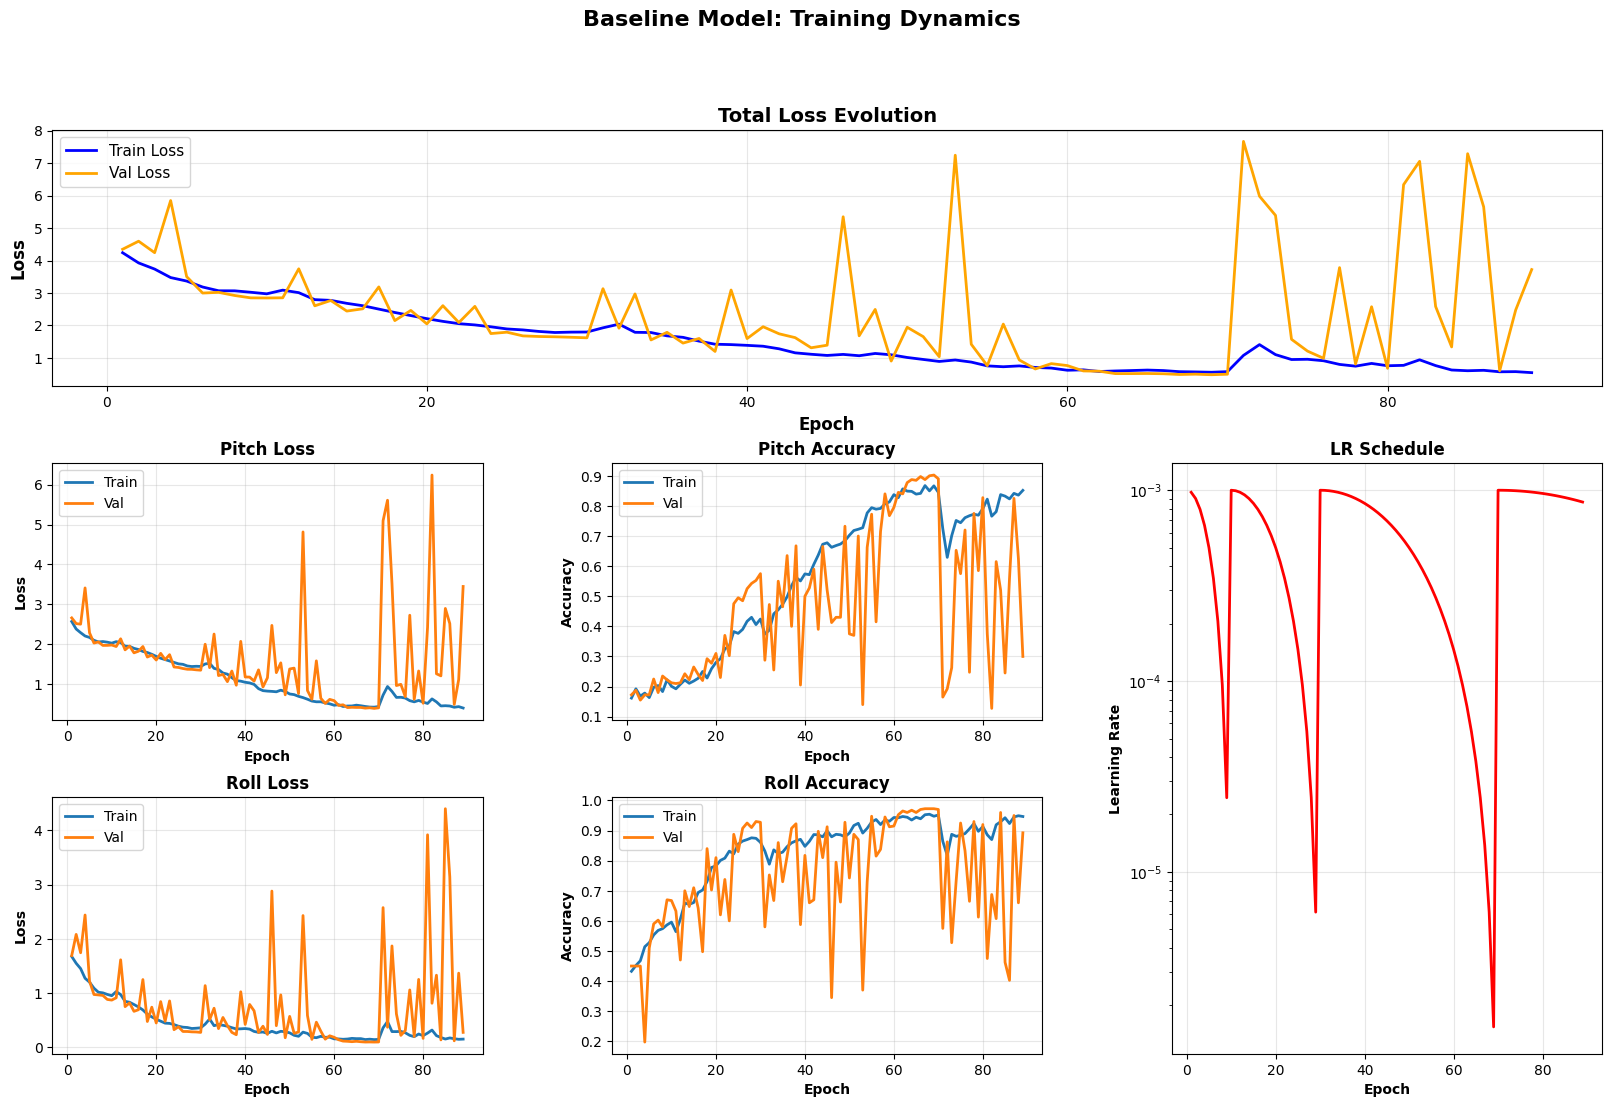

In [16]:
plot_training_curves(
    tracker_history=baseline_tracker.history,
    save_path=project_root / 'reports' / '1_vanilla_cnn_training_curves.png',
    title='Baseline Model: Training Dynamics'
)

### 4.2 Test Set Evaluation

In [ ]:
# Load best model
baseline_model.load_state_dict(torch.load(project_root / 'models' / '1_vanilla_cnn_baseline_best.pth'))
baseline_model.eval()

# Evaluate on test set
test_metrics = validate_epoch(
    baseline_model, test_loader,
    criterion_pitch, criterion_roll,
    device
)

print("Test Set Performance:")
print(f"   Loss: {test_metrics['loss']:.4f}")
print(f"   Pitch Accuracy: {test_metrics['pitch_acc']:.4f}")
print(f"   Roll Accuracy: {test_metrics['roll_acc']:.4f}")
print(f"   Average Accuracy: {(test_metrics['pitch_acc'] + test_metrics['roll_acc'])/2:.4f}")

Test Set Performance:
   Loss: 0.4719
   Pitch Accuracy: 0.8925
   Roll Accuracy: 0.9600
   Average Accuracy: 0.9263


In [11]:
test_predictions = collect_predictions(
    model=baseline_model,
    dataloader=test_loader,
    device=device
)

print("Predictions collected using collect_predictions() utility")
print(f"   Pitch predictions shape: {test_predictions['pitch_preds'].shape}")
print(f"   Roll predictions shape: {test_predictions['roll_preds'].shape}")

Predictions collected using collect_predictions() utility
   Pitch predictions shape: (400,)
   Roll predictions shape: (400,)


### 4.3 Confusion Matrices

In [21]:
pitch_names = [mappings['pitch_inv'][i] for i in range(mappings['num_pitch_classes'])]
roll_names = [mappings['roll_inv'][i] for i in range(mappings['num_roll_classes'])]

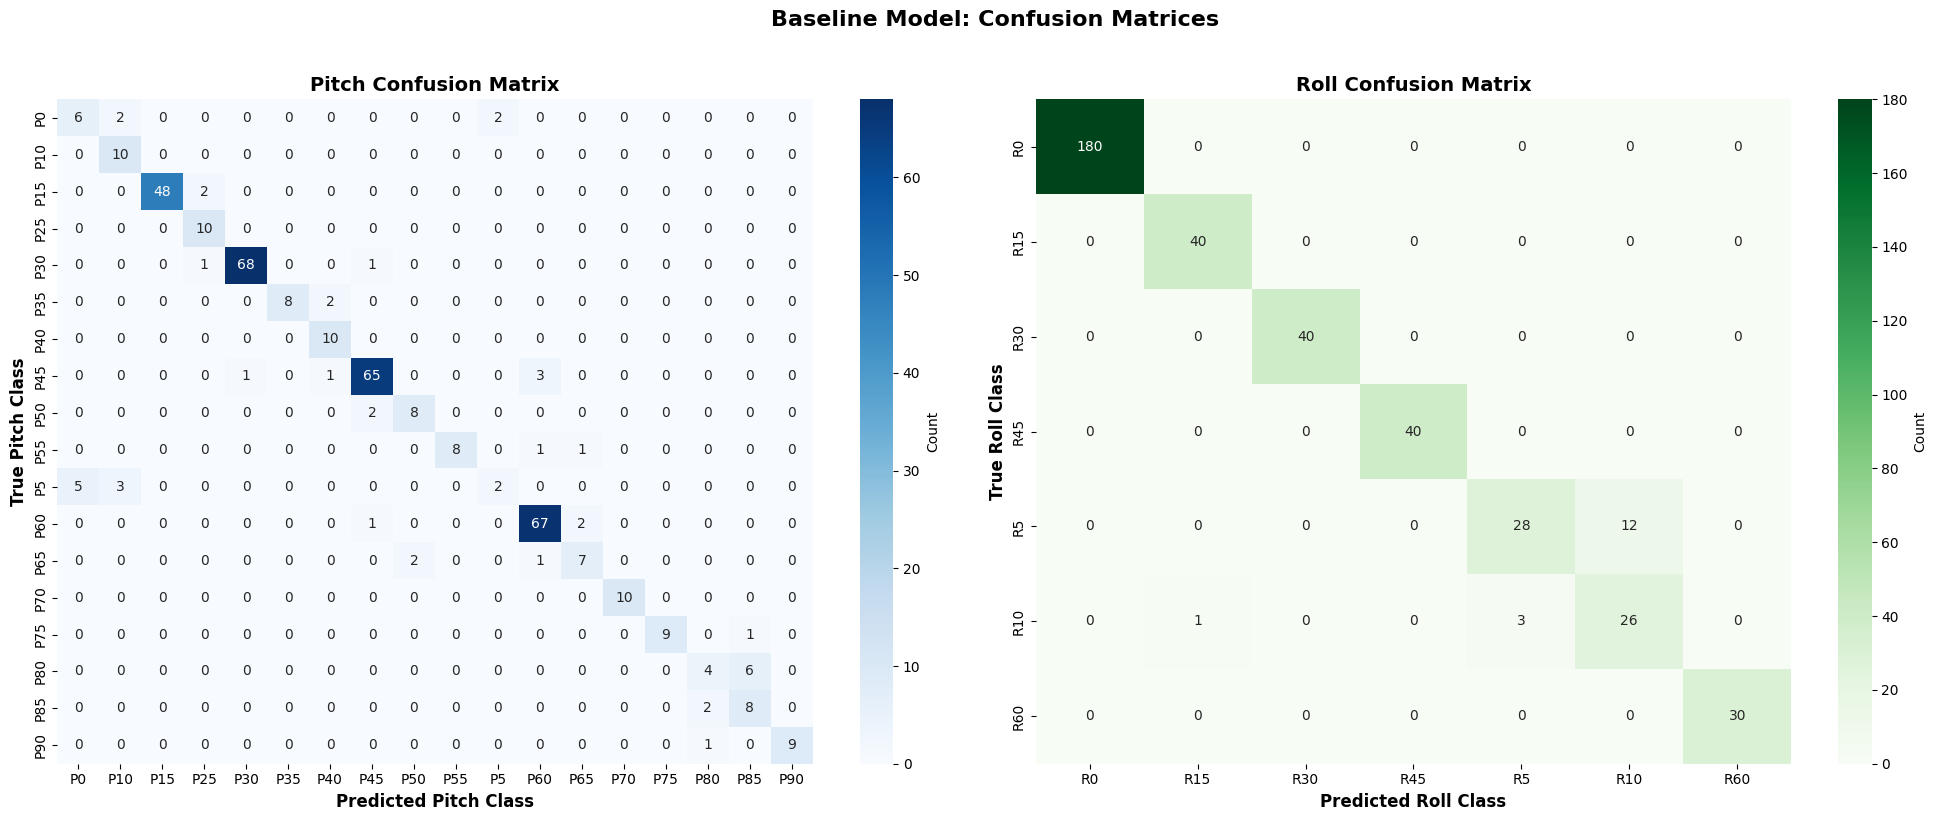

In [ ]:
plot_confusion_matrices(
    predictions=test_predictions,
    class_names_pitch=pitch_names,
    class_names_roll=roll_names,
    save_path=project_root / 'reports' / '1_vanilla_cnn_confusion_matrices.png',
    title='Baseline Model: Confusion Matrices'
)


### 4.4 Per-Class Performance Analysis

In [ ]:
# Use utility function for classification reports (REPLACES manual reporting)
pitch_report, roll_report = generate_classification_report(
    predictions=test_predictions,
    class_names_pitch=pitch_names,
    class_names_roll=roll_names
)

print("Pitch Classification Report:")
print(pitch_report)

print("\nRoll Classification Report:")
print(roll_report)

Pitch Classification Report:
              precision    recall  f1-score   support

          P0       0.55      0.60      0.57        10
         P10       0.67      1.00      0.80        10
         P15       1.00      0.96      0.98        50
         P25       0.77      1.00      0.87        10
         P30       0.99      0.97      0.98        70
         P35       1.00      0.80      0.89        10
         P40       0.77      1.00      0.87        10
         P45       0.94      0.93      0.94        70
         P50       0.80      0.80      0.80        10
         P55       1.00      0.80      0.89        10
          P5       0.50      0.20      0.29        10
         P60       0.93      0.96      0.94        70
         P65       0.70      0.70      0.70        10
         P70       1.00      1.00      1.00        10
         P75       1.00      0.90      0.95        10
         P80       0.57      0.40      0.47        10
         P85       0.53      0.80      0.64        1

## 5. Hyperparameter Tuning (Optuna)

Neural Architecture Search using Optuna for optimal hyperparameters.

In [31]:
# Define Optuna objective function

def objective(trial):
    """
    Optuna objective function for hyperparameter tuning
    """
    
    # Sample hyperparameters
    num_blocks = trial.suggest_int('num_blocks', 3, 5)
    
    channels = []
    for i in range(num_blocks):
        if i == 0:
            ch = trial.suggest_int(f'channels_stage{i}', 16, 64, step=16)
        elif i == 1:
            ch = trial.suggest_int(f'channels_stage{i}', 32, 128, step=32)
        else:
            ch = trial.suggest_int(f'channels_stage{i}', 64, 256, step=64)
        channels.append(ch)
    
    fc_dim = trial.suggest_int('fc_dim', 64, 512, step=64)
    lr = trial.suggest_float('lr', 1e-5, 5e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    use_bn = trial.suggest_categorical('use_bn', [True, False])
    
    # Initialize model
    model = VanillaCNN(
        num_pitch_classes=len(full_dataset.p_dict),
        num_roll_classes=len(full_dataset.r_dict),
        channels=channels,
        fc_dim=fc_dim,
        dropout_rate=dropout_rate,
        use_bn=use_bn
    ).to(device)
    
    # Loss and optimizer
    criterion_p = nn.CrossEntropyLoss()
    criterion_r = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5)
    
    # Train for limited epochs (for hyperparameter search)
    num_epochs = 20
    best_val_acc = 0
    
    for epoch in range(num_epochs):
      
        train_metrics = train_epoch(model, train_loader, criterion_p, criterion_r, optimizer, device)
        
        # Validate
        val_metrics = validate_epoch(model, val_loader, criterion_p, criterion_r, device)
        
        scheduler.step()
        
        # Track best
        val_acc_avg = (val_metrics['pitch_acc'] + val_metrics['roll_acc']) / 2
        best_val_acc = max(best_val_acc, val_acc_avg)
        
        # Report intermediate value for pruning
        trial.report(val_acc_avg, epoch)
        
        # Handle pruning
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return best_val_acc


print("Optuna objective function defined")
print("Will use existing train_loader and val_loader for hyperparameter search")

Optuna objective function defined
Will use existing train_loader and val_loader for hyperparameter search


In [32]:
# Run Optuna study: hyperparameter search

study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
)

study.optimize(objective, n_trials=50, timeout=None, show_progress_bar=True)

print("\nHyperparameter search completed")
print(f"\n Best trial:")
print(f"   Value (accuracy): {study.best_value:.4f}")
print(f"   Params: {study.best_params}")

[I 2025-12-08 16:11:44,892] A new study created in memory with name: no-name-61006b3a-1547-4ae4-8e73-87ec7ee08b08
Best trial: 0. Best value: 0.3125:   2%|▏         | 1/50 [03:41<3:00:57, 221.58s/it]

[I 2025-12-08 16:15:26,459] Trial 0 finished with value: 0.3125 and parameters: {'num_blocks': 4, 'channels_stage0': 64, 'channels_stage1': 128, 'channels_stage2': 192, 'channels_stage3': 128, 'fc_dim': 512, 'lr': 0.043970829416158645, 'dropout_rate': 0.27097613252654523, 'use_bn': False}. Best is trial 0 with value: 0.3125.


Best trial: 1. Best value: 0.4475:   4%|▍         | 2/50 [05:40<2:08:58, 161.23s/it]

[I 2025-12-08 16:17:25,451] Trial 1 finished with value: 0.4475 and parameters: {'num_blocks': 5, 'channels_stage0': 32, 'channels_stage1': 32, 'channels_stage2': 128, 'channels_stage3': 128, 'channels_stage4': 64, 'fc_dim': 384, 'lr': 0.0007811827501040059, 'dropout_rate': 0.10535113380774452, 'use_bn': True}. Best is trial 1 with value: 0.4475.


Best trial: 1. Best value: 0.4475:   6%|▌         | 3/50 [08:48<2:15:58, 173.58s/it]

[I 2025-12-08 16:20:33,729] Trial 2 finished with value: 0.3275 and parameters: {'num_blocks': 4, 'channels_stage0': 64, 'channels_stage1': 96, 'channels_stage2': 192, 'channels_stage3': 64, 'fc_dim': 256, 'lr': 4.141210741857627e-05, 'dropout_rate': 0.32524391296490074, 'use_bn': False}. Best is trial 1 with value: 0.4475.


Best trial: 1. Best value: 0.4475:   8%|▊         | 4/50 [12:29<2:27:15, 192.08s/it]

[I 2025-12-08 16:24:14,170] Trial 3 finished with value: 0.39125 and parameters: {'num_blocks': 4, 'channels_stage0': 64, 'channels_stage1': 96, 'channels_stage2': 64, 'channels_stage3': 64, 'fc_dim': 128, 'lr': 0.001843482346728246, 'dropout_rate': 0.19500305624977615, 'use_bn': True}. Best is trial 1 with value: 0.4475.


Best trial: 1. Best value: 0.4475:  10%|█         | 5/50 [14:39<2:07:20, 169.80s/it]

[I 2025-12-08 16:26:24,466] Trial 4 finished with value: 0.315 and parameters: {'num_blocks': 4, 'channels_stage0': 32, 'channels_stage1': 64, 'channels_stage2': 256, 'channels_stage3': 192, 'fc_dim': 256, 'lr': 0.0014661517188845224, 'dropout_rate': 0.18480044571391824, 'use_bn': False}. Best is trial 1 with value: 0.4475.


Best trial: 1. Best value: 0.4475:  12%|█▏        | 6/50 [15:45<1:38:32, 134.37s/it]

[I 2025-12-08 16:27:30,066] Trial 5 pruned. 


Best trial: 1. Best value: 0.4475:  14%|█▍        | 7/50 [17:55<1:35:21, 133.07s/it]

[I 2025-12-08 16:29:40,449] Trial 6 finished with value: 0.32875 and parameters: {'num_blocks': 3, 'channels_stage0': 32, 'channels_stage1': 64, 'channels_stage2': 128, 'fc_dim': 448, 'lr': 0.0001292328092972398, 'dropout_rate': 0.3723697182491554, 'use_bn': True}. Best is trial 1 with value: 0.4475.


Best trial: 1. Best value: 0.4475:  16%|█▌        | 8/50 [18:45<1:14:35, 106.57s/it]

[I 2025-12-08 16:30:30,271] Trial 7 pruned. 


Best trial: 1. Best value: 0.4475:  18%|█▊        | 9/50 [21:51<1:29:54, 131.59s/it]

[I 2025-12-08 16:33:36,869] Trial 8 finished with value: 0.39375 and parameters: {'num_blocks': 4, 'channels_stage0': 64, 'channels_stage1': 96, 'channels_stage2': 128, 'channels_stage3': 256, 'fc_dim': 448, 'lr': 0.00797616067653942, 'dropout_rate': 0.142511811798739, 'use_bn': False}. Best is trial 1 with value: 0.4475.


Best trial: 1. Best value: 0.4475:  20%|██        | 10/50 [22:59<1:14:32, 111.81s/it]

[I 2025-12-08 16:34:44,395] Trial 9 pruned. 


Best trial: 1. Best value: 0.4475:  22%|██▏       | 11/50 [23:25<55:31, 85.43s/it]   

[I 2025-12-08 16:35:10,031] Trial 10 pruned. 


Best trial: 11. Best value: 0.565:  24%|██▍       | 12/50 [26:21<1:11:31, 112.95s/it]

[I 2025-12-08 16:38:05,902] Trial 11 finished with value: 0.565 and parameters: {'num_blocks': 5, 'channels_stage0': 48, 'channels_stage1': 32, 'channels_stage2': 128, 'channels_stage3': 256, 'channels_stage4': 64, 'fc_dim': 320, 'lr': 0.00855545138521057, 'dropout_rate': 0.07997367986522128, 'use_bn': True}. Best is trial 11 with value: 0.565.


Best trial: 11. Best value: 0.565:  26%|██▌       | 13/50 [27:17<59:04, 95.79s/it]   

[I 2025-12-08 16:39:02,198] Trial 12 pruned. 


Best trial: 13. Best value: 0.5925:  28%|██▊       | 14/50 [28:51<57:09, 95.25s/it]

[I 2025-12-08 16:40:36,215] Trial 13 finished with value: 0.5925 and parameters: {'num_blocks': 5, 'channels_stage0': 16, 'channels_stage1': 32, 'channels_stage2': 128, 'channels_stage3': 192, 'channels_stage4': 64, 'fc_dim': 192, 'lr': 0.010891826117034962, 'dropout_rate': 0.0970653119102845, 'use_bn': True}. Best is trial 13 with value: 0.5925.


Best trial: 13. Best value: 0.5925:  30%|███       | 15/50 [30:22<54:53, 94.10s/it]

[I 2025-12-08 16:42:07,639] Trial 14 finished with value: 0.51875 and parameters: {'num_blocks': 5, 'channels_stage0': 16, 'channels_stage1': 32, 'channels_stage2': 64, 'channels_stage3': 256, 'channels_stage4': 128, 'fc_dim': 192, 'lr': 0.04850703142707187, 'dropout_rate': 0.07650996236598784, 'use_bn': True}. Best is trial 13 with value: 0.5925.


Best trial: 13. Best value: 0.5925:  32%|███▏      | 16/50 [33:22<1:08:00, 120.02s/it]

[I 2025-12-08 16:45:07,858] Trial 15 finished with value: 0.44375 and parameters: {'num_blocks': 5, 'channels_stage0': 48, 'channels_stage1': 32, 'channels_stage2': 192, 'channels_stage3': 192, 'channels_stage4': 256, 'fc_dim': 192, 'lr': 0.00821612927130424, 'dropout_rate': 0.03624233439505407, 'use_bn': True}. Best is trial 13 with value: 0.5925.


Best trial: 13. Best value: 0.5925:  34%|███▍      | 17/50 [35:17<1:05:10, 118.50s/it]

[I 2025-12-08 16:47:02,815] Trial 16 finished with value: 0.51625 and parameters: {'num_blocks': 5, 'channels_stage0': 16, 'channels_stage1': 64, 'channels_stage2': 128, 'channels_stage3': 256, 'channels_stage4': 128, 'fc_dim': 192, 'lr': 0.0175993029784275, 'dropout_rate': 0.1405721156247275, 'use_bn': True}. Best is trial 13 with value: 0.5925.


Best trial: 13. Best value: 0.5925:  36%|███▌      | 18/50 [39:33<1:25:09, 159.66s/it]

[I 2025-12-08 16:51:18,296] Trial 17 finished with value: 0.4625 and parameters: {'num_blocks': 5, 'channels_stage0': 48, 'channels_stage1': 128, 'channels_stage2': 192, 'channels_stage3': 192, 'channels_stage4': 64, 'fc_dim': 64, 'lr': 0.0029401108248598047, 'dropout_rate': 0.23884854291068122, 'use_bn': True}. Best is trial 13 with value: 0.5925.


Best trial: 13. Best value: 0.5925:  38%|███▊      | 19/50 [40:00<1:01:54, 119.84s/it]

[I 2025-12-08 16:51:45,371] Trial 18 pruned. 


Best trial: 13. Best value: 0.5925:  40%|████      | 20/50 [42:16<1:02:21, 124.72s/it]

[I 2025-12-08 16:54:01,455] Trial 19 finished with value: 0.48250000000000004 and parameters: {'num_blocks': 4, 'channels_stage0': 32, 'channels_stage1': 64, 'channels_stage2': 128, 'channels_stage3': 192, 'fc_dim': 320, 'lr': 0.004675267903002803, 'dropout_rate': 0.0014753049364438636, 'use_bn': True}. Best is trial 13 with value: 0.5925.


Best trial: 13. Best value: 0.5925:  42%|████▏     | 21/50 [43:45<55:04, 113.94s/it]  

[I 2025-12-08 16:55:30,271] Trial 20 pruned. 


Best trial: 13. Best value: 0.5925:  44%|████▍     | 22/50 [44:51<46:30, 99.65s/it] 

[I 2025-12-08 16:56:36,599] Trial 21 pruned. 


Best trial: 13. Best value: 0.5925:  46%|████▌     | 23/50 [46:18<43:07, 95.82s/it]

[I 2025-12-08 16:58:03,483] Trial 22 finished with value: 0.5599999999999999 and parameters: {'num_blocks': 5, 'channels_stage0': 16, 'channels_stage1': 32, 'channels_stage2': 64, 'channels_stage3': 256, 'channels_stage4': 64, 'fc_dim': 128, 'lr': 0.0190502392004212, 'dropout_rate': 0.08765020874247473, 'use_bn': True}. Best is trial 13 with value: 0.5925.


Best trial: 23. Best value: 0.60375:  48%|████▊     | 24/50 [47:55<41:43, 96.27s/it]

[I 2025-12-08 16:59:40,818] Trial 23 finished with value: 0.60375 and parameters: {'num_blocks': 5, 'channels_stage0': 16, 'channels_stage1': 64, 'channels_stage2': 64, 'channels_stage3': 192, 'channels_stage4': 64, 'fc_dim': 128, 'lr': 0.005222250512059205, 'dropout_rate': 0.17098430801901304, 'use_bn': True}. Best is trial 23 with value: 0.60375.


Best trial: 23. Best value: 0.60375:  50%|█████     | 25/50 [49:37<40:46, 97.88s/it]

[I 2025-12-08 17:01:22,427] Trial 24 pruned. 


Best trial: 25. Best value: 0.65375:  52%|█████▏    | 26/50 [51:22<40:02, 100.10s/it]

[I 2025-12-08 17:03:07,724] Trial 25 finished with value: 0.65375 and parameters: {'num_blocks': 5, 'channels_stage0': 16, 'channels_stage1': 64, 'channels_stage2': 128, 'channels_stage3': 128, 'channels_stage4': 64, 'fc_dim': 384, 'lr': 0.0053694375685918545, 'dropout_rate': 0.1516001884473194, 'use_bn': True}. Best is trial 25 with value: 0.65375.


Best trial: 25. Best value: 0.65375:  54%|█████▍    | 27/50 [51:55<30:39, 79.97s/it] 

[I 2025-12-08 17:03:40,732] Trial 26 pruned. 


Best trial: 25. Best value: 0.65375:  56%|█████▌    | 28/50 [52:47<26:15, 71.62s/it]

[I 2025-12-08 17:04:32,852] Trial 27 pruned. 


Best trial: 25. Best value: 0.65375:  58%|█████▊    | 29/50 [54:20<27:12, 77.76s/it]

[I 2025-12-08 17:06:04,934] Trial 28 finished with value: 0.46625 and parameters: {'num_blocks': 5, 'channels_stage0': 16, 'channels_stage1': 64, 'channels_stage2': 64, 'channels_stage3': 64, 'channels_stage4': 128, 'fc_dim': 384, 'lr': 0.011102219116220202, 'dropout_rate': 0.2687454575947247, 'use_bn': True}. Best is trial 25 with value: 0.65375.


Best trial: 25. Best value: 0.65375:  60%|██████    | 30/50 [56:22<30:23, 91.20s/it]

[I 2025-12-08 17:08:07,497] Trial 29 pruned. 


Best trial: 25. Best value: 0.65375:  62%|██████▏   | 31/50 [58:33<32:40, 103.16s/it]

[I 2025-12-08 17:10:18,570] Trial 30 finished with value: 0.47624999999999995 and parameters: {'num_blocks': 5, 'channels_stage0': 32, 'channels_stage1': 64, 'channels_stage2': 128, 'channels_stage3': 128, 'channels_stage4': 64, 'fc_dim': 256, 'lr': 0.01951380949418797, 'dropout_rate': 0.30831882359398066, 'use_bn': True}. Best is trial 25 with value: 0.65375.


Best trial: 25. Best value: 0.65375:  64%|██████▍   | 32/50 [59:06<24:34, 81.92s/it] 

[I 2025-12-08 17:10:50,945] Trial 31 pruned. 


Best trial: 25. Best value: 0.65375:  66%|██████▌   | 33/50 [1:00:58<25:47, 91.04s/it]

[I 2025-12-08 17:12:43,236] Trial 32 finished with value: 0.56 and parameters: {'num_blocks': 5, 'channels_stage0': 32, 'channels_stage1': 32, 'channels_stage2': 128, 'channels_stage3': 128, 'channels_stage4': 64, 'fc_dim': 384, 'lr': 0.00998675404612233, 'dropout_rate': 0.10727053817696003, 'use_bn': True}. Best is trial 25 with value: 0.65375.


Best trial: 25. Best value: 0.65375:  68%|██████▊   | 34/50 [1:03:47<30:31, 114.48s/it]

[I 2025-12-08 17:15:32,424] Trial 33 finished with value: 0.51375 and parameters: {'num_blocks': 5, 'channels_stage0': 48, 'channels_stage1': 64, 'channels_stage2': 128, 'channels_stage3': 192, 'channels_stage4': 64, 'fc_dim': 384, 'lr': 0.001188515739203229, 'dropout_rate': 0.039461670900076615, 'use_bn': True}. Best is trial 25 with value: 0.65375.


Best trial: 25. Best value: 0.65375:  70%|███████   | 35/50 [1:04:58<25:21, 101.41s/it]

[I 2025-12-08 17:16:43,348] Trial 34 pruned. 


Best trial: 25. Best value: 0.65375:  72%|███████▏  | 36/50 [1:06:43<23:54, 102.46s/it]

[I 2025-12-08 17:18:28,252] Trial 35 finished with value: 0.49875 and parameters: {'num_blocks': 5, 'channels_stage0': 32, 'channels_stage1': 32, 'channels_stage2': 64, 'channels_stage3': 192, 'channels_stage4': 64, 'fc_dim': 192, 'lr': 0.00212835966655186, 'dropout_rate': 0.21804011906101758, 'use_bn': True}. Best is trial 25 with value: 0.65375.


Best trial: 25. Best value: 0.65375:  74%|███████▍  | 37/50 [1:07:07<17:05, 78.89s/it] 

[I 2025-12-08 17:18:52,134] Trial 36 pruned. 


Best trial: 25. Best value: 0.65375:  76%|███████▌  | 38/50 [1:08:04<14:27, 72.26s/it]

[I 2025-12-08 17:19:48,916] Trial 37 pruned. 


Best trial: 25. Best value: 0.65375:  78%|███████▊  | 39/50 [1:08:41<11:18, 61.68s/it]

[I 2025-12-08 17:20:25,919] Trial 38 pruned. 


Best trial: 25. Best value: 0.65375:  80%|████████  | 40/50 [1:10:36<12:59, 77.92s/it]

[I 2025-12-08 17:22:21,712] Trial 39 pruned. 


Best trial: 25. Best value: 0.65375:  82%|████████▏ | 41/50 [1:11:14<09:52, 65.87s/it]

[I 2025-12-08 17:22:59,479] Trial 40 pruned. 


Best trial: 25. Best value: 0.65375:  84%|████████▍ | 42/50 [1:13:06<10:36, 79.62s/it]

[I 2025-12-08 17:24:51,175] Trial 41 finished with value: 0.6175 and parameters: {'num_blocks': 5, 'channels_stage0': 32, 'channels_stage1': 32, 'channels_stage2': 128, 'channels_stage3': 128, 'channels_stage4': 64, 'fc_dim': 384, 'lr': 0.008325942003018862, 'dropout_rate': 0.10584255326039906, 'use_bn': True}. Best is trial 25 with value: 0.65375.


Best trial: 25. Best value: 0.65375:  86%|████████▌ | 43/50 [1:14:35<09:37, 82.45s/it]

[I 2025-12-08 17:26:20,241] Trial 42 finished with value: 0.52625 and parameters: {'num_blocks': 5, 'channels_stage0': 16, 'channels_stage1': 32, 'channels_stage2': 128, 'channels_stage3': 128, 'channels_stage4': 64, 'fc_dim': 448, 'lr': 0.0033411702099357446, 'dropout_rate': 0.08815664319526974, 'use_bn': True}. Best is trial 25 with value: 0.65375.


Best trial: 43. Best value: 0.6975:  88%|████████▊ | 44/50 [1:17:00<10:07, 101.17s/it]

[I 2025-12-08 17:28:45,093] Trial 43 finished with value: 0.6975 and parameters: {'num_blocks': 5, 'channels_stage0': 48, 'channels_stage1': 32, 'channels_stage2': 128, 'channels_stage3': 128, 'channels_stage4': 64, 'fc_dim': 384, 'lr': 0.00838979810732048, 'dropout_rate': 0.12924459201016825, 'use_bn': True}. Best is trial 43 with value: 0.6975.


Best trial: 43. Best value: 0.6975:  90%|█████████ | 45/50 [1:18:31<08:10, 98.08s/it] 

[I 2025-12-08 17:30:15,964] Trial 44 pruned. 


Best trial: 43. Best value: 0.6975:  92%|█████████▏| 46/50 [1:20:01<06:22, 95.67s/it]

[I 2025-12-08 17:31:46,023] Trial 45 finished with value: 0.6487499999999999 and parameters: {'num_blocks': 5, 'channels_stage0': 16, 'channels_stage1': 32, 'channels_stage2': 128, 'channels_stage3': 128, 'channels_stage4': 128, 'fc_dim': 384, 'lr': 0.006135908912407619, 'dropout_rate': 0.155034250673991, 'use_bn': True}. Best is trial 43 with value: 0.6975.


Best trial: 43. Best value: 0.6975:  94%|█████████▍| 47/50 [1:22:26<05:31, 110.66s/it]

[I 2025-12-08 17:34:11,663] Trial 46 finished with value: 0.6387499999999999 and parameters: {'num_blocks': 5, 'channels_stage0': 48, 'channels_stage1': 32, 'channels_stage2': 128, 'channels_stage3': 128, 'channels_stage4': 192, 'fc_dim': 384, 'lr': 0.0023057893464023785, 'dropout_rate': 0.18411515789586794, 'use_bn': True}. Best is trial 43 with value: 0.6975.


Best trial: 43. Best value: 0.6975:  96%|█████████▌| 48/50 [1:22:59<02:54, 87.40s/it] 

[I 2025-12-08 17:34:44,791] Trial 47 pruned. 


Best trial: 43. Best value: 0.6975:  98%|█████████▊| 49/50 [1:25:20<01:43, 103.34s/it]

[I 2025-12-08 17:37:05,322] Trial 48 finished with value: 0.58375 and parameters: {'num_blocks': 5, 'channels_stage0': 48, 'channels_stage1': 32, 'channels_stage2': 128, 'channels_stage3': 64, 'channels_stage4': 192, 'fc_dim': 448, 'lr': 0.0012503282727388413, 'dropout_rate': 0.29326038580877406, 'use_bn': True}. Best is trial 43 with value: 0.6975.


Best trial: 43. Best value: 0.6975: 100%|██████████| 50/50 [1:28:22<00:00, 106.05s/it]

[I 2025-12-08 17:40:07,225] Trial 49 finished with value: 0.62875 and parameters: {'num_blocks': 5, 'channels_stage0': 64, 'channels_stage1': 32, 'channels_stage2': 128, 'channels_stage3': 128, 'channels_stage4': 192, 'fc_dim': 384, 'lr': 0.006985155348977239, 'dropout_rate': 0.1541255581718007, 'use_bn': True}. Best is trial 43 with value: 0.6975.

Hyperparameter search completed

 Best trial:
   Value (accuracy): 0.6975
   Params: {'num_blocks': 5, 'channels_stage0': 48, 'channels_stage1': 32, 'channels_stage2': 128, 'channels_stage3': 128, 'channels_stage4': 64, 'fc_dim': 384, 'lr': 0.00838979810732048, 'dropout_rate': 0.12924459201016825, 'use_bn': True}


## 6. Final Model Training & Analysis

Train final model with optimized hyperparameters and perform comprehensive analysis.

In [35]:
# Extract best hyperparameters and reconstruct channels list
best_params = study.best_params
num_blocks = best_params['num_blocks']
channels_opt = [best_params[f'channels_stage{i}'] for i in range(num_blocks)]

print("🏆 Best Hyperparameters:")
print(f"   Num blocks: {num_blocks}")
print(f"   Channels: {channels_opt}")
print(f"   FC dim: {best_params['fc_dim']}")
print(f"   Learning rate: {best_params['lr']:.6f}")
print(f"   Dropout: {best_params['dropout_rate']:.3f}")
print(f"   Batch norm: {best_params['use_bn']}")

🏆 Best Hyperparameters:
   Num blocks: 5
   Channels: [48, 32, 128, 128, 64]
   FC dim: 384
   Learning rate: 0.008390
   Dropout: 0.129
   Batch norm: True


In [9]:
best_model_config = {
    'channels': [48, 32, 128, 128, 64],
    'fc_dim': 384,
    'lr': 0.008390,
    'dropout_rate': 0.129,
    'use_bn': True
}

In [10]:
# Initialize optimized model
optimized_model = VanillaCNN(
    num_pitch_classes=len(full_dataset.p_dict),
    num_roll_classes=len(full_dataset.r_dict),
    channels=best_model_config['channels'],
    fc_dim=best_model_config['fc_dim'],
    dropout_rate=best_model_config['dropout_rate'],
    use_bn=best_model_config['use_bn']
).to(device)

# No need to create new loaders - train_loader, val_loader, test_loader already exist

# Optimizer and scheduler
optimizer_final = torch.optim.AdamW(
    optimized_model.parameters(),
    lr=best_model_config['lr'],
    weight_decay=1e-4
)
scheduler_final = CosineAnnealingWarmRestarts(optimizer_final, T_0=10, T_mult=2)

# Metrics tracker
final_tracker = MetricsTracker()

print(f"Optimized model initialized")
print(f"  Parameters: {optimized_model.get_num_params():,}")
print(f"  Using existing data loaders (train_loader, val_loader, test_loader)")

Optimized model initialized
  Parameters: 308,953
  Using existing data loaders (train_loader, val_loader, test_loader)


### Train optimized model

In [ ]:
# Train optimized model
best_val_acc_opt = 0
patience = 40
patience_counter = 0
num_epochs_final = 130

for epoch in range(1, num_epochs_final + 1):
    # Train (using existing train_loader and val_loader)
    train_metrics = train_epoch(
        optimized_model, train_loader,
        criterion_pitch, criterion_roll,
        optimizer_final, device
    )
    
    # Validate
    val_metrics = validate_epoch(
        optimized_model, val_loader,
        criterion_pitch, criterion_roll,
        device
    )
    
    # Update scheduler
    scheduler_final.step()
    current_lr = optimizer_final.param_groups[0]['lr']
    
    # Track metrics
    final_tracker.update({
        'train_loss': train_metrics['loss'],
        'train_pitch_loss': train_metrics['pitch_loss'],
        'train_roll_loss': train_metrics['roll_loss'],
        'train_pitch_acc': train_metrics['pitch_acc'],
        'train_roll_acc': train_metrics['roll_acc'],
        'val_loss': val_metrics['loss'],
        'val_pitch_loss': val_metrics['pitch_loss'],
        'val_roll_loss': val_metrics['roll_loss'],
        'val_pitch_acc': val_metrics['pitch_acc'],
        'val_roll_acc': val_metrics['roll_acc'],
        'lr': current_lr
    })
    
    # Save best model
    val_acc_avg = (val_metrics['pitch_acc'] + val_metrics['roll_acc']) / 2
    if val_acc_avg > best_val_acc_opt:
        best_val_acc_opt = val_acc_avg
        torch.save(optimized_model.state_dict(), project_root / 'models' / '2_vanilla_cnn_optimized_best.pth')
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Print progress
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}/{num_epochs_final}")
        print(f"  Train - Loss: {train_metrics['loss']:.4f} | "
              f"Pitch Acc: {train_metrics['pitch_acc']:.3f} | "
              f"Roll Acc: {train_metrics['roll_acc']:.3f}")
        print(f"  Val   - Loss: {val_metrics['loss']:.4f} | "
              f"Pitch Acc: {val_metrics['pitch_acc']:.3f} | "
              f"Roll Acc: {val_metrics['roll_acc']:.3f}")
        print(f"  LR: {current_lr:.6f}\n")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break

print(f"\n Optimized model training completed")
print(f"   Best validation accuracy: {best_val_acc_opt:.4f}")

### Final Evaluation & Comparison

In [ ]:
# Load and evaluate optimized model on test set
optimized_model.load_state_dict(torch.load(project_root / 'models' / '2_vanilla_cnn_optimized_best.pth'))
optimized_model.eval()

# Collect predictions for optimized model (using utility and existing test_loader)
test_predictions_opt = collect_predictions(
    model=optimized_model,
    dataloader=test_loader,
    device=device
)

In [ ]:
# Load and evaluate optimized model on test set
baseline_model.load_state_dict(torch.load(project_root / 'models' / '1_vanilla_cnn_baseline_best.pth'))
baseline_model.eval()

# Collect predictions for baseline model (using utility and existing test_loader)
test_predictions = collect_predictions(
    model=baseline_model,
    dataloader=test_loader,
    device=device
)

In [18]:
# Compute comprehensive metrics (using utility)
baseline_metrics = compute_metrics(test_predictions)
optimized_metrics = compute_metrics(test_predictions_opt)

# Compute computational cost (using utility)
baseline_cost = compute_computational_cost(baseline_model, device=device)
optimized_cost = compute_computational_cost(optimized_model, device=device)

print("\n" + "="*70)
print("FINAL COMPARISON: Baseline vs Optimized")
print("="*70)

# Use utility function for model summary (REPLACES manual printing)
print("\n📊 BASELINE MODEL:")
print_model_summary(baseline_model, "Vanilla CNN (Baseline)", baseline_metrics, baseline_cost)

print("\n🏆 OPTIMIZED MODEL:")
print_model_summary(optimized_model, "Vanilla CNN (Optimized)", optimized_metrics, optimized_cost)

# Calculate improvement
baseline_avg = (baseline_metrics['pitch']['accuracy'] + baseline_metrics['roll']['accuracy']) / 2
optimized_avg = (optimized_metrics['pitch']['accuracy'] + optimized_metrics['roll']['accuracy']) / 2
improvement = optimized_avg - baseline_avg

print("\n" + "="*70)
print(f"IMPROVEMENT: {improvement:+.4f} ({improvement*100:+.2f}%)")
print("="*70)

print("\nFinal comparison completed using utility functions:")


FINAL COMPARISON: Baseline vs Optimized

📊 BASELINE MODEL:

MODEL SUMMARY: Vanilla CNN (Baseline)

📊 PERFORMANCE METRICS
   Pitch Accuracy:  0.8925
   Pitch Precision: 0.8965
   Pitch Recall:    0.8925
   Pitch F1:        0.8895

   Roll Accuracy:   0.9600
   Roll Precision:  0.9642
   Roll Recall:     0.9600
   Roll F1:         0.9600

   Average Accuracy: 0.9263

💻 COMPUTATIONAL COST
   Parameters:      1.71M
   Inference Time:  4.57 ± 2.61 ms
   Memory:          6.52 MB


🏆 OPTIMIZED MODEL:

MODEL SUMMARY: Vanilla CNN (Optimized)

📊 PERFORMANCE METRICS
   Pitch Accuracy:  0.9775
   Pitch Precision: 0.9817
   Pitch Recall:    0.9775
   Pitch F1:        0.9779

   Roll Accuracy:   0.9900
   Roll Precision:  0.9903
   Roll Recall:     0.9900
   Roll F1:         0.9900

   Average Accuracy: 0.9838

💻 COMPUTATIONAL COST
   Parameters:      0.31M
   Inference Time:  3.06 ± 3.12 ms
   Memory:          1.18 MB


IMPROVEMENT: +0.0575 (+5.75%)

Final comparison completed using utility functi

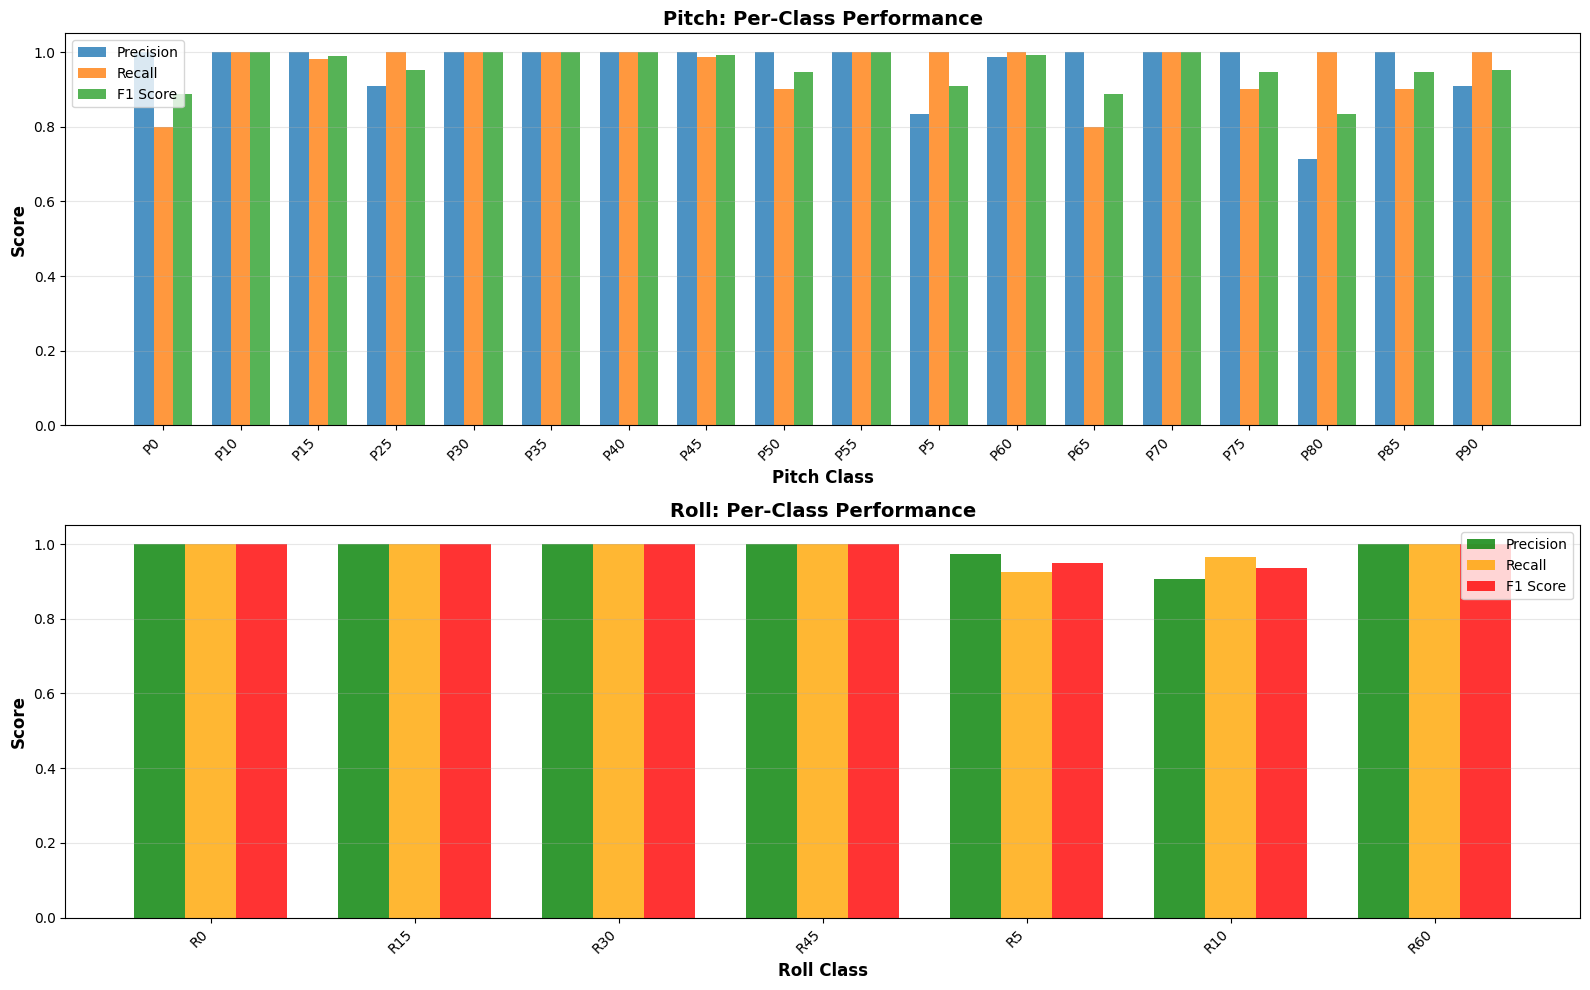

Per-class performance metrics visualized


In [ ]:
# Plot per-class performance (using utility)
plot_per_class_performance(
    predictions=test_predictions_opt,
    class_names_pitch=pitch_names,
    class_names_roll=roll_names,
    save_path=project_root / 'reports' / '1_vanilla_cnn_per_class_performance.png',
)

print("Per-class performance metrics visualized")

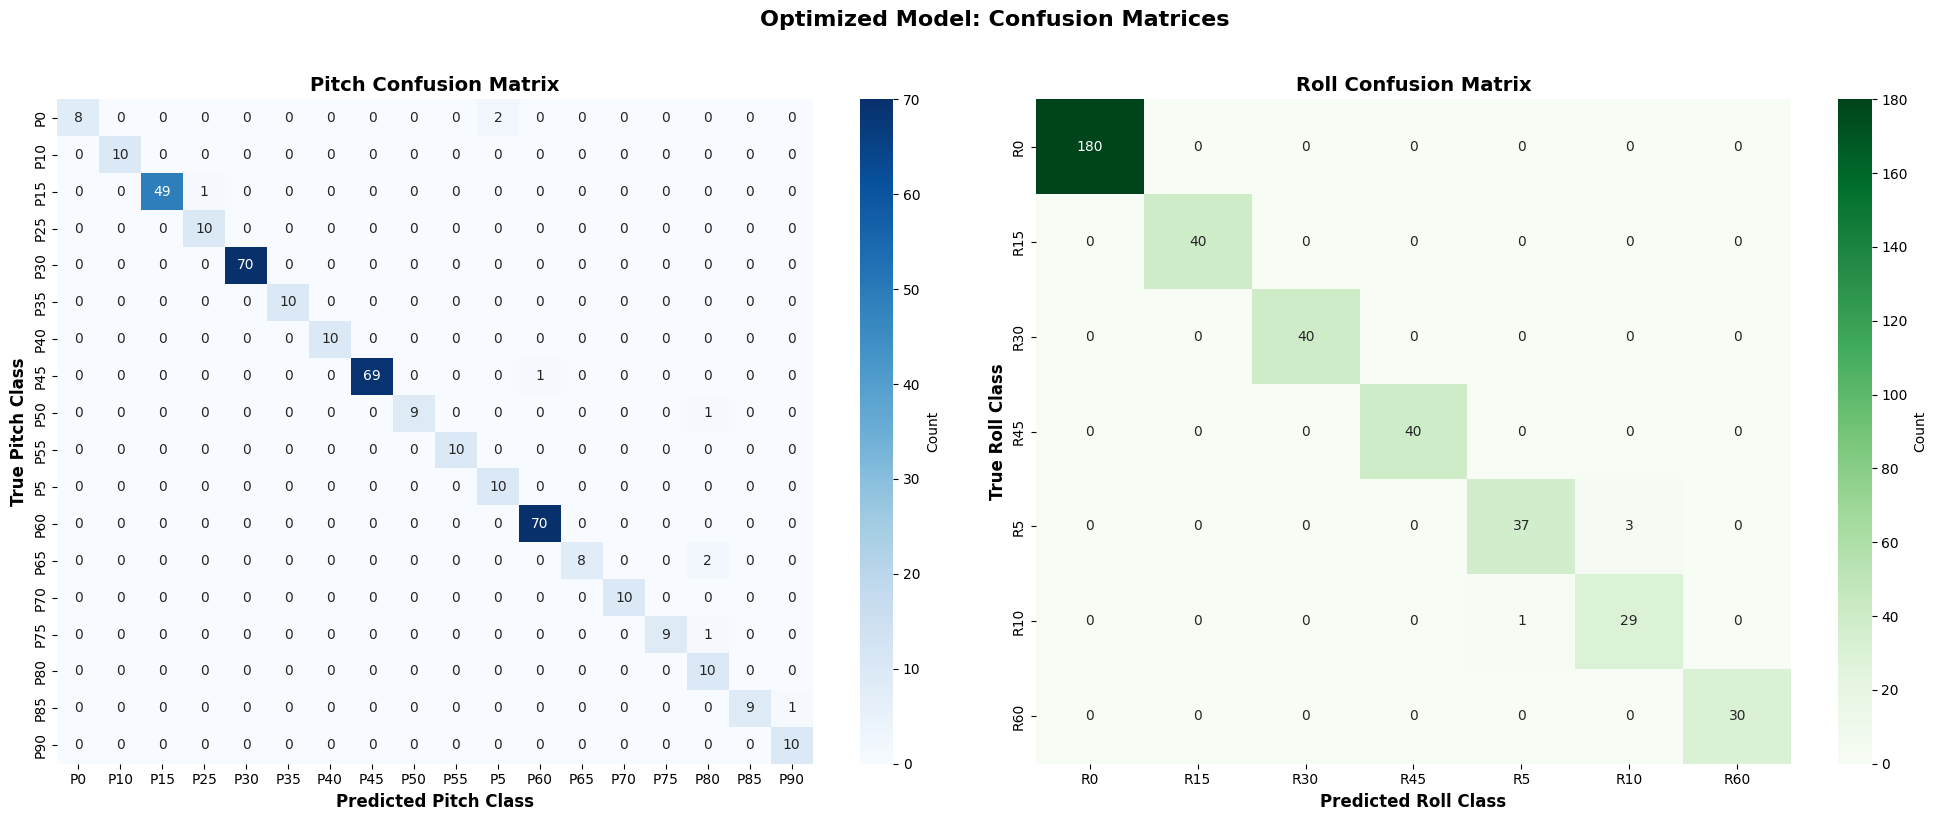

Optimized model confusion matrices plotted


In [54]:

plot_confusion_matrices(
    predictions=test_predictions_opt,
    class_names_pitch=pitch_names,
    class_names_roll=roll_names,
    save_path=project_root / 'reports' / '1_vanilla_cnn_optimized_confusion_matrices.png',
    title='Optimized Model: Confusion Matrices'
)

print("Optimized model confusion matrices plotted")

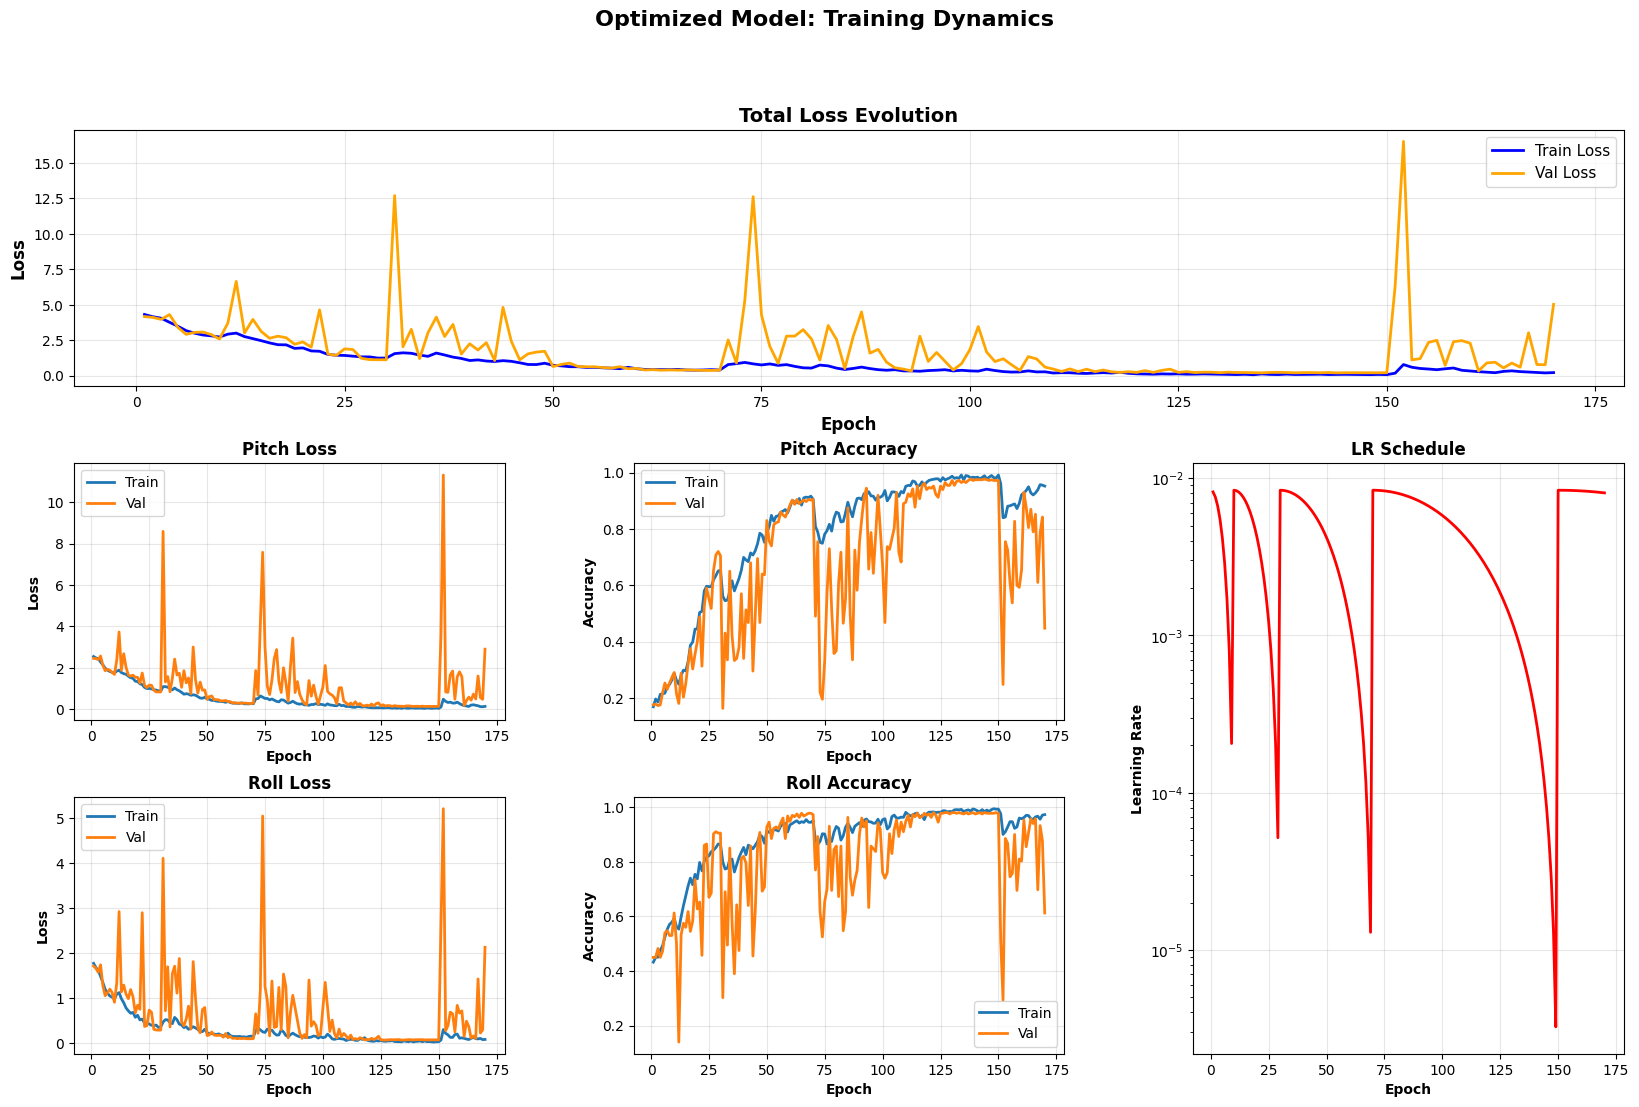

Optimized model training curves plotted


In [55]:
# Plot training curves for optimized model (using utility)
plot_training_curves(
    tracker_history=final_tracker.history,
    save_path=project_root / 'reports' / '1_vanilla_cnn_optimized_training_curves.png',
    title='Optimized Model: Training Dynamics'
)

print("Optimized model training curves plotted")

### Optimized Model: Additional Visualizations

### 7.1 Systematic Error Analysis

In [22]:
# Use analyze_errors utility to identify systematic misclassification patterns
from src.utils import analyze_errors

error_analysis = analyze_errors(
    predictions=test_predictions_opt,
    class_names_pitch=pitch_names,
    class_names_roll=roll_names,
    top_k=10
)

print("="*70)
print("SYSTEMATIC ERROR ANALYSIS")
print("="*70)

print(f"\n Overall Error Rates:")
print(f"   Pitch Error Rate: {error_analysis['pitch_error_rate']*100:.2f}%")
print(f"   Roll Error Rate: {error_analysis['roll_error_rate']*100:.2f}%")
print(f"   Total Misclassified (Pitch): {len(error_analysis['pitch_error_indices'])}/{len(test_predictions_opt['pitch_labels'])}")
print(f"   Total Misclassified (Roll): {len(error_analysis['roll_error_indices'])}/{len(test_predictions_opt['roll_labels'])}")

print(f"\n Top 10 Most Confused Pitch Class Pairs:")
for i, pair in enumerate(error_analysis['pitch_confusion_pairs'][:10], 1):
    print(f"   {i}. {pair['true_class']} → {pair['pred_class']}: {pair['count']} errors")

print(f"\n Top 10 Most Confused Roll Class Pairs:")
for i, pair in enumerate(error_analysis['roll_confusion_pairs'][:10], 1):
    print(f"   {i}. {pair['true_class']} → {pair['pred_class']}: {pair['count']} errors")

print(f"\n⚠️  Low Confidence Predictions (Pitch):")
low_conf_pitch_indices = error_analysis['low_confidence_pitch'][:5]
for idx in low_conf_pitch_indices:
    true_label = test_predictions_opt['pitch_labels'][idx]
    pred_label = test_predictions_opt['pitch_preds'][idx]
    confidence = test_predictions_opt['pitch_probs'][idx].max()
    print(f"   Sample {idx}: True={pitch_names[true_label]}, Pred={pitch_names[pred_label]}, Conf={confidence:.3f}")

print(f"\n⚠️  Low Confidence Predictions (Roll):")
low_conf_roll_indices = error_analysis['low_confidence_roll'][:5]
for idx in low_conf_roll_indices:
    true_label = test_predictions_opt['roll_labels'][idx]
    pred_label = test_predictions_opt['roll_preds'][idx]
    confidence = test_predictions_opt['roll_probs'][idx].max()
    print(f"   Sample {idx}: True={roll_names[true_label]}, Pred={roll_names[pred_label]}, Conf={confidence:.3f}")

SYSTEMATIC ERROR ANALYSIS

 Overall Error Rates:
   Pitch Error Rate: 2.25%
   Roll Error Rate: 1.00%
   Total Misclassified (Pitch): 9/400
   Total Misclassified (Roll): 4/400

 Top 10 Most Confused Pitch Class Pairs:
   1. P0 → P5: 2 errors
   2. P65 → P80: 2 errors
   3. P15 → P25: 1 errors
   4. P45 → P60: 1 errors
   5. P50 → P80: 1 errors
   6. P75 → P80: 1 errors
   7. P85 → P90: 1 errors

 Top 10 Most Confused Roll Class Pairs:
   1. R5 → R10: 3 errors
   2. R10 → R5: 1 errors

⚠️  Low Confidence Predictions (Pitch):
   Sample 310: True=P30, Pred=P30, Conf=0.516
   Sample 307: True=P45, Pred=P45, Conf=0.529
   Sample 311: True=P40, Pred=P40, Conf=0.544
   Sample 302: True=P50, Pred=P50, Conf=0.574
   Sample 189: True=P60, Pred=P60, Conf=0.588

⚠️  Low Confidence Predictions (Roll):
   Sample 75: True=R10, Pred=R10, Conf=0.541
   Sample 180: True=R10, Pred=R10, Conf=0.617
   Sample 108: True=R15, Pred=R15, Conf=0.648
   Sample 143: True=R5, Pred=R5, Conf=0.694
   Sample 66: True

### 7.2 Error Distribution Histograms

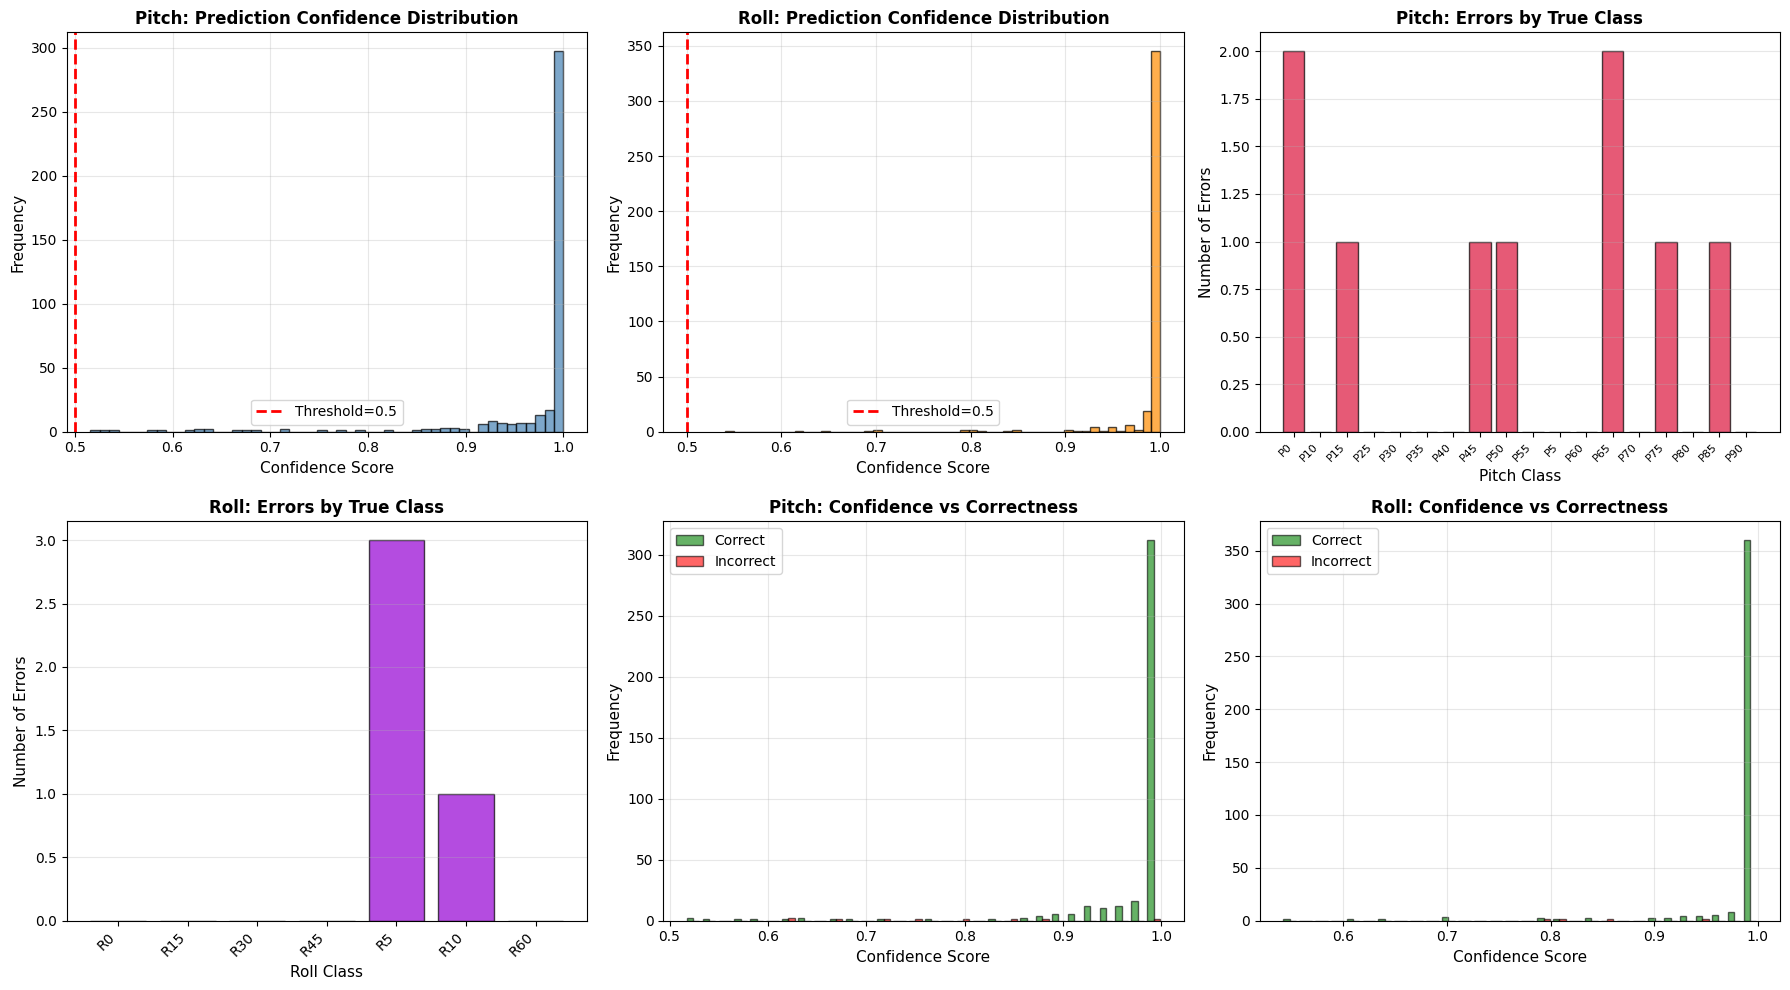

✅ Error distribution histograms created


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Create error distribution visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Pitch prediction confidence histogram
axes[0, 0].hist(test_predictions_opt['pitch_probs'].max(axis=1), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[0, 0].set_xlabel('Confidence Score', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Pitch: Prediction Confidence Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Roll prediction confidence histogram
axes[0, 1].hist(test_predictions_opt['roll_probs'].max(axis=1), bins=50, color='darkorange', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[0, 1].set_xlabel('Confidence Score', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Roll: Prediction Confidence Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Errors by pitch class
pitch_error_counts = np.zeros(len(pitch_names))
for idx in error_analysis['pitch_error_indices']:
    pitch_error_counts[test_predictions_opt['pitch_labels'][idx]] += 1
axes[0, 2].bar(range(len(pitch_names)), pitch_error_counts, color='crimson', edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Pitch Class', fontsize=11)
axes[0, 2].set_ylabel('Number of Errors', fontsize=11)
axes[0, 2].set_title('Pitch: Errors by True Class', fontsize=12, fontweight='bold')
axes[0, 2].set_xticks(range(len(pitch_names)))
axes[0, 2].set_xticklabels(pitch_names, rotation=45, ha='right', fontsize=8)
axes[0, 2].grid(alpha=0.3, axis='y')

# 4. Errors by roll class
roll_error_counts = np.zeros(len(roll_names))
for idx in error_analysis['roll_error_indices']:
    roll_error_counts[test_predictions_opt['roll_labels'][idx]] += 1
axes[1, 0].bar(range(len(roll_names)), roll_error_counts, color='darkviolet', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Roll Class', fontsize=11)
axes[1, 0].set_ylabel('Number of Errors', fontsize=11)
axes[1, 0].set_title('Roll: Errors by True Class', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(range(len(roll_names)))
axes[1, 0].set_xticklabels(roll_names, rotation=45, ha='right')
axes[1, 0].grid(alpha=0.3, axis='y')

# 5. Confidence vs Correctness (Pitch)
correct_mask_pitch = test_predictions_opt['pitch_preds'] == test_predictions_opt['pitch_labels']
correct_conf_pitch = test_predictions_opt['pitch_probs'].max(axis=1)[correct_mask_pitch]
incorrect_conf_pitch = test_predictions_opt['pitch_probs'].max(axis=1)[~correct_mask_pitch]
axes[1, 1].hist([correct_conf_pitch, incorrect_conf_pitch], bins=30, label=['Correct', 'Incorrect'], 
                color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[1, 1].set_xlabel('Confidence Score', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Pitch: Confidence vs Correctness', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 6. Confidence vs Correctness (Roll)
correct_mask_roll = test_predictions_opt['roll_preds'] == test_predictions_opt['roll_labels']
correct_conf_roll = test_predictions_opt['roll_probs'].max(axis=1)[correct_mask_roll]
incorrect_conf_roll = test_predictions_opt['roll_probs'].max(axis=1)[~correct_mask_roll]
axes[1, 2].hist([correct_conf_roll, incorrect_conf_roll], bins=30, label=['Correct', 'Incorrect'], 
                color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[1, 2].set_xlabel('Confidence Score', fontsize=11)
axes[1, 2].set_ylabel('Frequency', fontsize=11)
axes[1, 2].set_title('Roll: Confidence vs Correctness', fontsize=12, fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'reports' / '1_vanilla_cnn_error_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Error distribution histograms created")

### 7.3 Worst Predictions Gallery

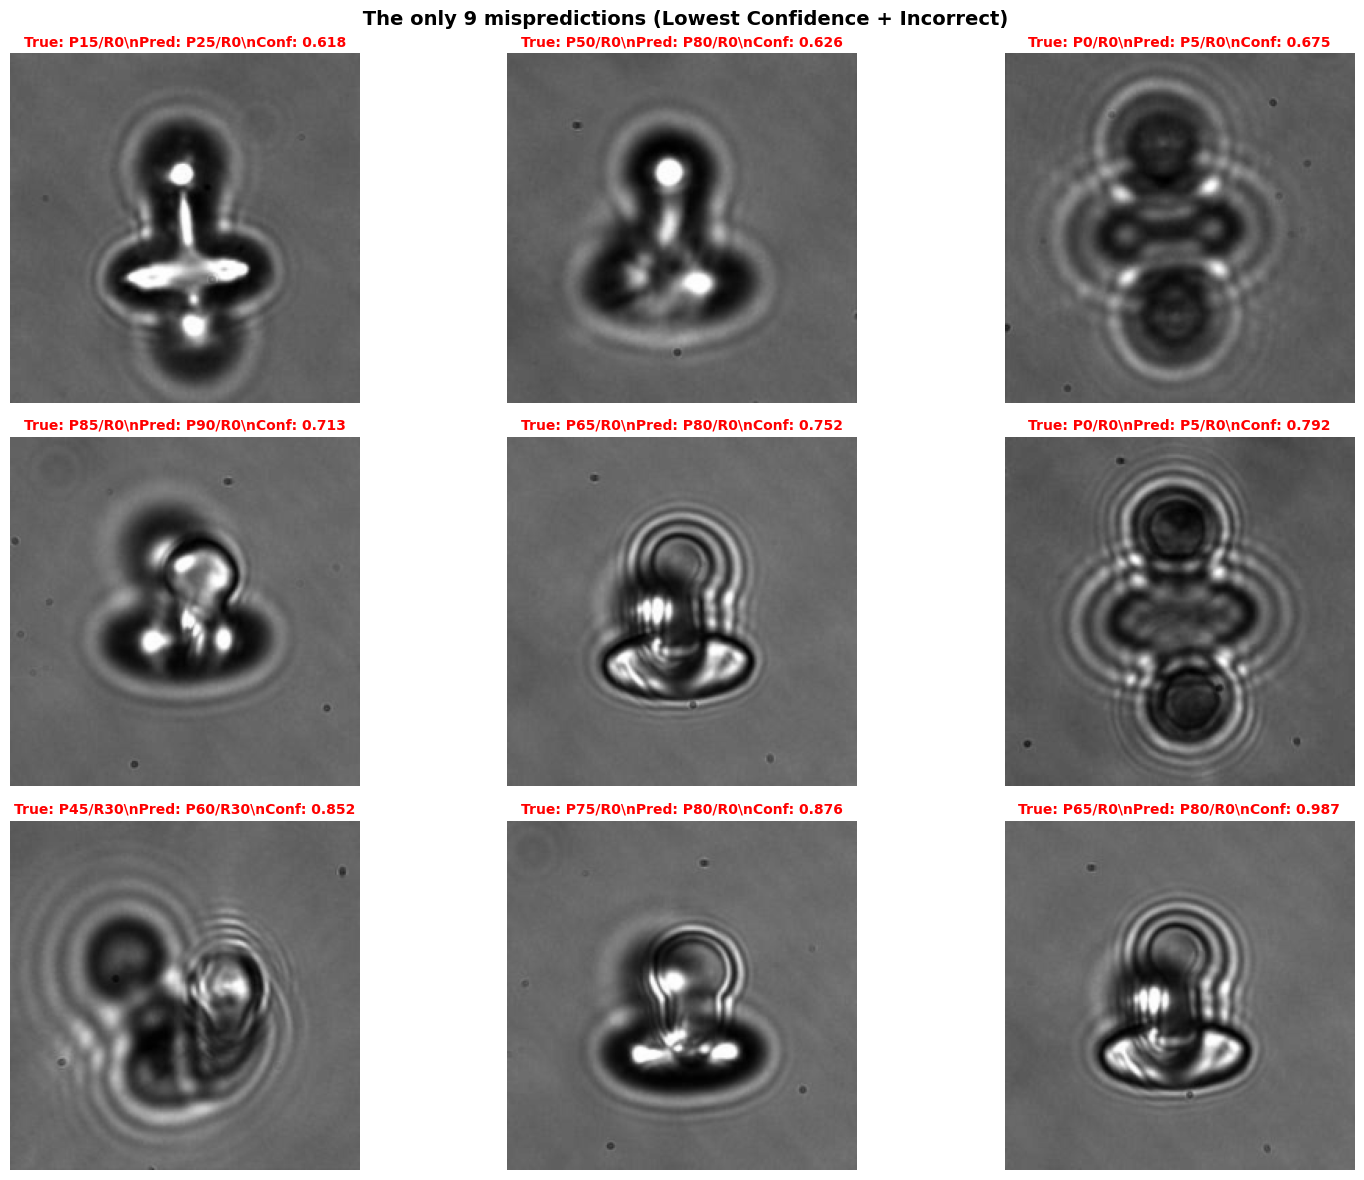

 Gallery of 9 worst predictions created


In [29]:
# Visualize worst predictions (lowest confidence + incorrect)
incorrect_pitch = test_predictions_opt['pitch_preds'] != test_predictions_opt['pitch_labels']
incorrect_pitch_indices = np.where(incorrect_pitch)[0]

if len(incorrect_pitch_indices) > 0:
    # Get confidence scores for incorrect predictions
    incorrect_confidences = test_predictions_opt['pitch_probs'][incorrect_pitch_indices].max(axis=1)
    
    # Sort by confidence (lowest first = worst predictions)
    worst_indices = incorrect_pitch_indices[np.argsort(incorrect_confidences)[:12]]
    
    # Create gallery
    fig, axes = plt.subplots(3, 3, figsize=(16, 12))
    axes = axes.ravel()
    
    for i, idx in enumerate(worst_indices):
        # Get image from test dataset
        img, (pitch_label, roll_label) = test_dataset[test_idx[idx]]
        
        # Denormalize image for display
        img_display = img.permute(1, 2, 0).numpy()
        img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
        
        # Get predictions
        true_pitch = pitch_names[test_predictions_opt['pitch_labels'][idx]]
        pred_pitch = pitch_names[test_predictions_opt['pitch_preds'][idx]]
        true_roll = roll_names[test_predictions_opt['roll_labels'][idx]]
        pred_roll = roll_names[test_predictions_opt['roll_preds'][idx]]
        conf = test_predictions_opt['pitch_probs'][idx].max()
        
        # Display
        axes[i].imshow(img_display)
        axes[i].axis('off')
        axes[i].set_title(f'True: {true_pitch}/{true_roll}\\nPred: {pred_pitch}/{pred_roll}\\nConf: {conf:.3f}',
                         fontsize=10, color='red', fontweight='bold')
    
    plt.suptitle(f' The only {len(worst_indices)} mispredictions (Lowest Confidence + Incorrect)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(project_root / 'reports' / '1_vanilla_cnn_worst_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f" Gallery of {len(worst_indices)} worst predictions created")
else:
    print("🎉 No incorrect predictions found!")

### 7.5 Grad-CAM Attention Heatmaps

Generating Grad-CAM visualizations for 6 samples...
  Sample 1: True=P30/R5, Pred=P30/R5, Conf=1.000


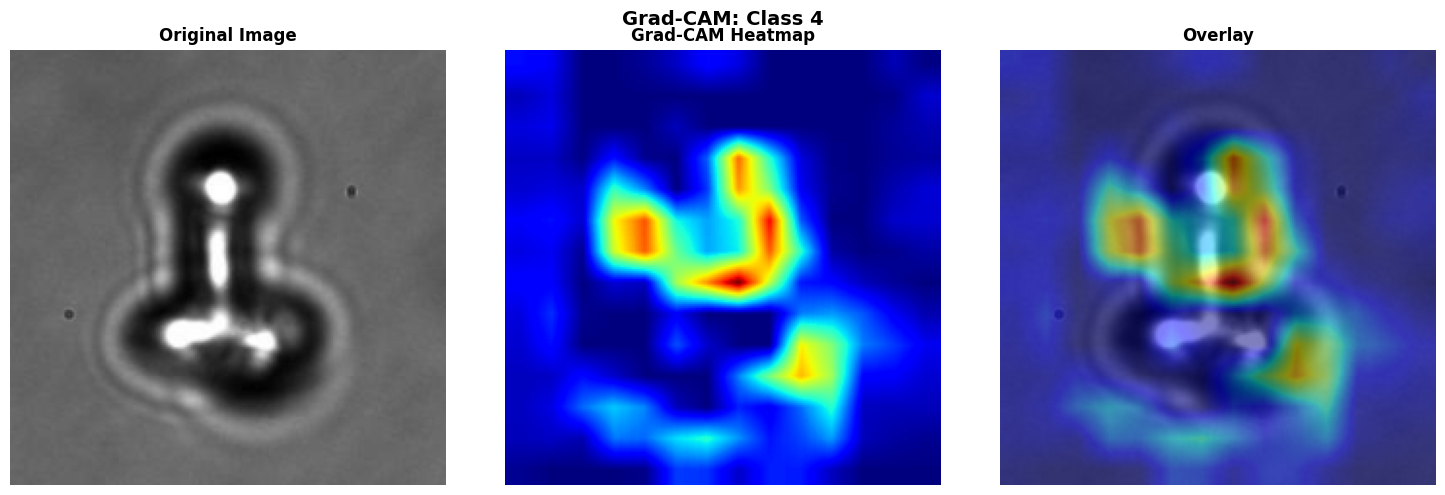

  Sample 2: True=P60/R0, Pred=P60/R0, Conf=0.999


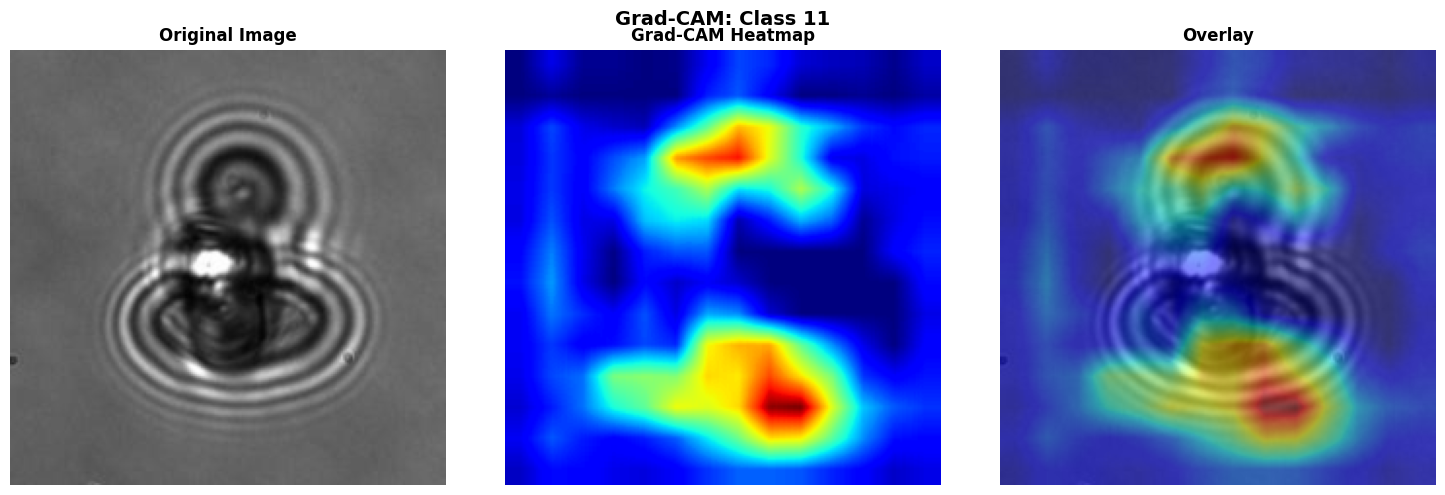

  Sample 3: True=P90/R0, Pred=P90/R0, Conf=0.995


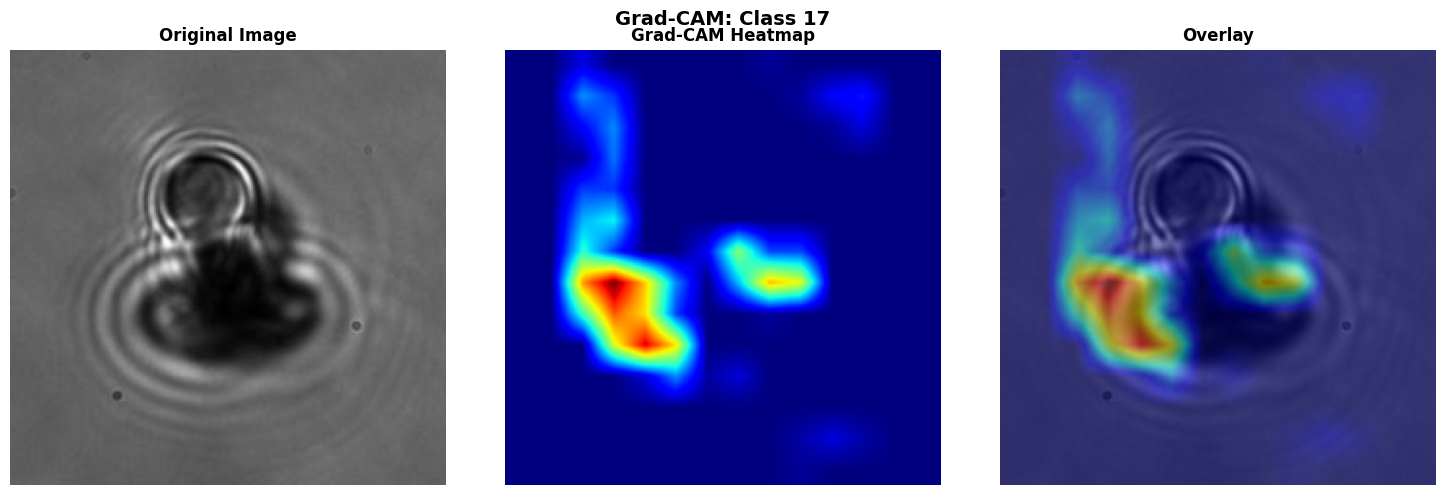

  Sample 4: True=P45/R5, Pred=P45/R5, Conf=0.999


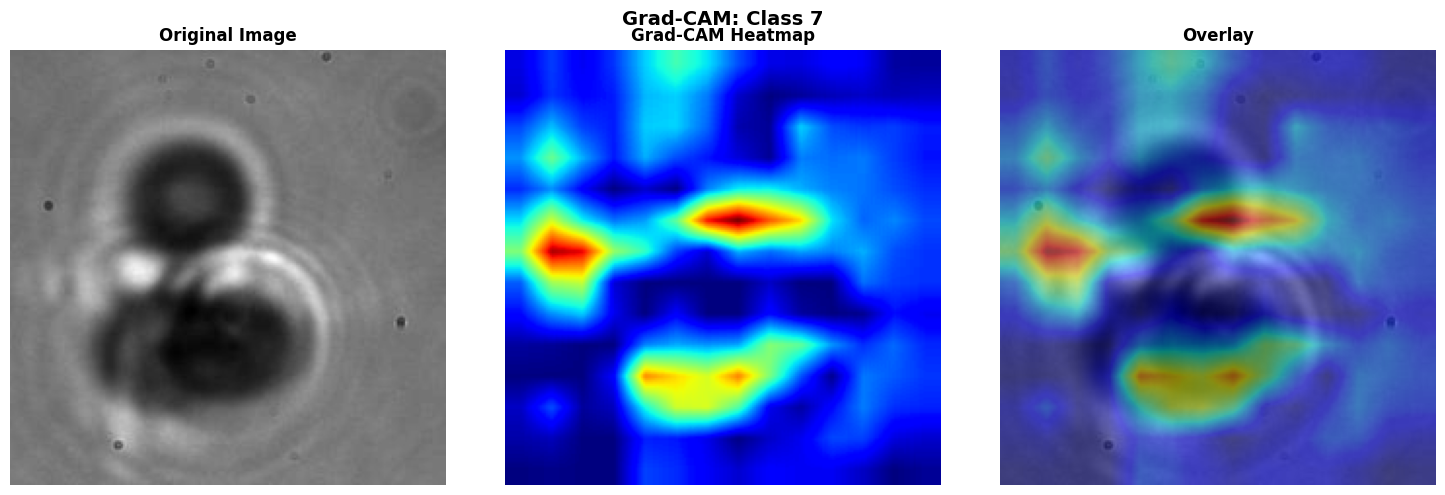

  Sample 5: True=P40/R0, Pred=P40/R0, Conf=0.996


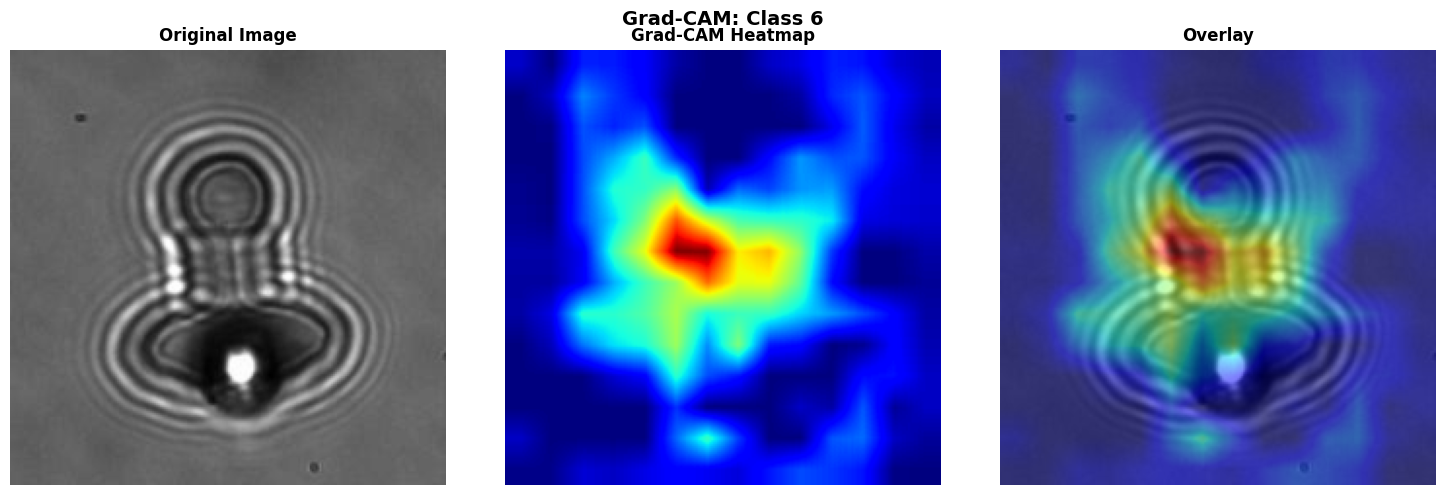

  Sample 6: True=P15/R0, Pred=P15/R0, Conf=0.931


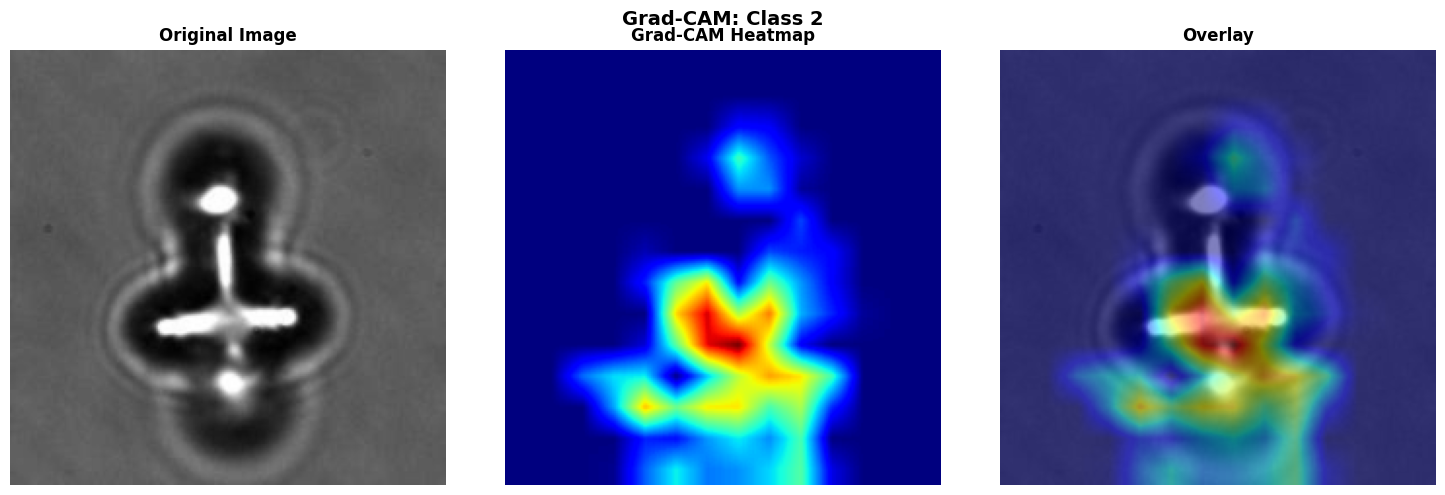


✅ Grad-CAM visualizations created for 6 samples
   Heatmaps show which regions the model focuses on for predictions


In [31]:
# Use plot_grad_cam utility for attention visualization
from src.utils import plot_grad_cam

# Visualize Grad-CAM for multiple samples
n_samples = 6

print(f"Generating Grad-CAM visualizations for {n_samples} samples...")

for i in range(n_samples):
    sample_img, (sample_pitch, sample_roll) = test_dataset[test_idx[i]]
    sample_img_batch = sample_img.unsqueeze(0).to(device)
    
    # Get labels
    true_pitch = pitch_names[test_predictions_opt['pitch_labels'][i]]
    true_roll = roll_names[test_predictions_opt['roll_labels'][i]]
    pred_pitch = pitch_names[test_predictions_opt['pitch_preds'][i]]
    pred_roll = roll_names[test_predictions_opt['roll_preds'][i]]
    conf = test_predictions_opt['pitch_probs'][i].max()
    
    # Generate Grad-CAM (using last conv layer)
    print(f"  Sample {i+1}: True={true_pitch}/{true_roll}, Pred={pred_pitch}/{pred_roll}, Conf={conf:.3f}")
    
    plot_grad_cam(
        model=optimized_model,
        image=sample_img_batch,
        target_layer_name='features.4.0',
        class_idx=test_predictions_opt['pitch_labels'][i],
        device=device,
        save_path=project_root / 'reports' / f'1_vanilla_cnn_gradcam_sample_{i}.png'
    )

print(f"\n✅ Grad-CAM visualizations created for {n_samples} samples")
print("   Heatmaps show which regions the model focuses on for predictions")

### 7.6 First Layer Filter Visualization

First layer filters shape: (64, 128, 3, 3)
Number of filters: 64
Filter size: 3x3


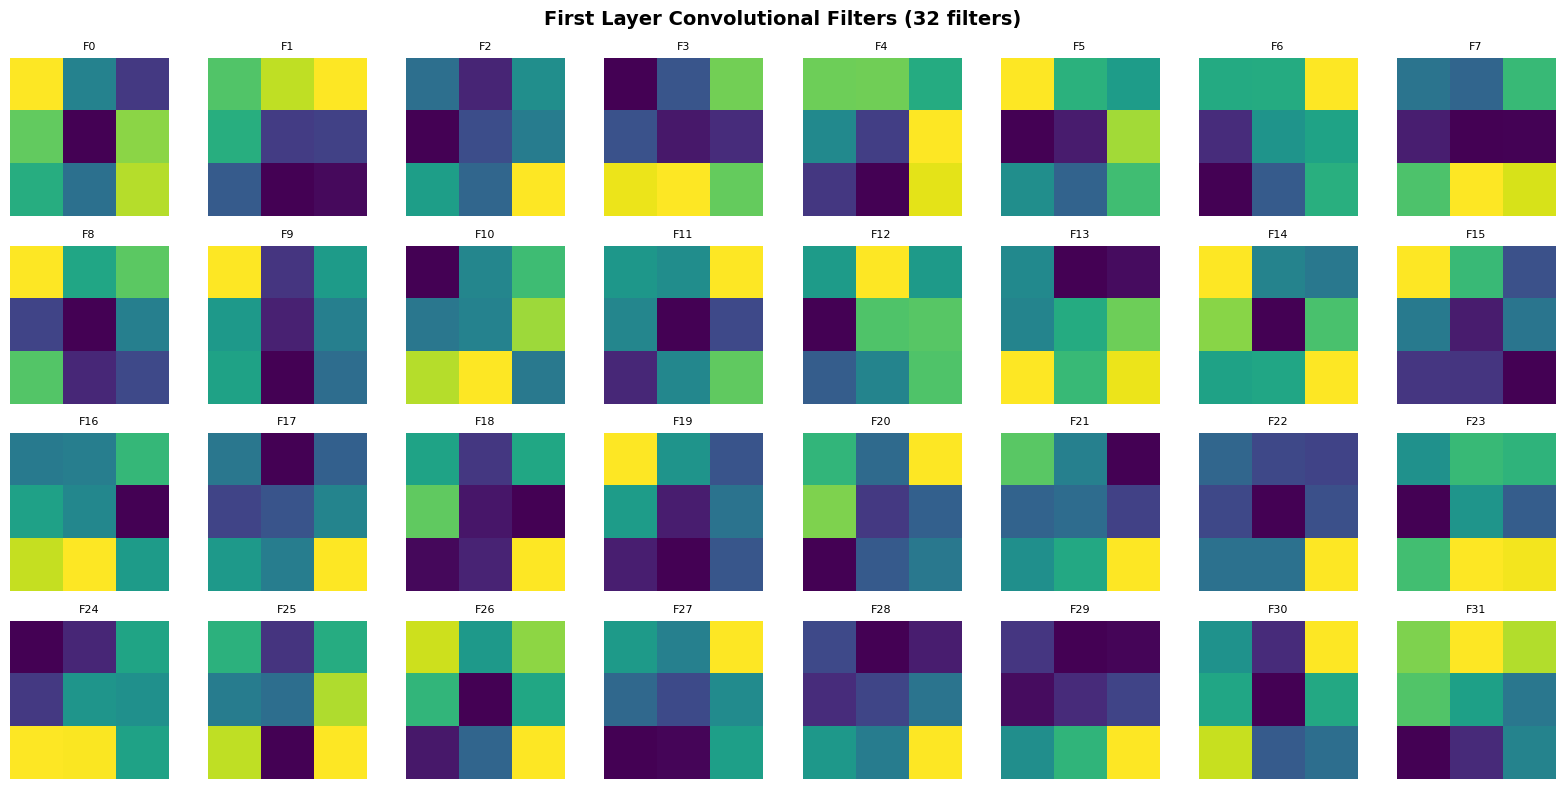

\n First layer filter visualization created
   These filters detect low-level features like edges, textures, and colors


In [32]:
# Visualize first layer convolutional filters
first_conv_layer = optimized_model.features[4][0]  # First conv layer
filters = first_conv_layer.weight.data.cpu().numpy()

print(f"First layer filters shape: {filters.shape}")
print(f"Number of filters: {filters.shape[0]}")
print(f"Filter size: {filters.shape[2]}x{filters.shape[3]}")

# Visualize first 32 filters
n_filters = min(32, filters.shape[0])
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
axes = axes.ravel()

for i in range(n_filters):
    # Get filter and normalize for visualization
    filt = filters[i]
    
    # Convert to grayscale by averaging across RGB channels
    filt_gray = filt.mean(axis=0)
    
    # Normalize to [0, 1]
    filt_gray = (filt_gray - filt_gray.min()) / (filt_gray.max() - filt_gray.min() + 1e-8)
    
    # Display
    axes[i].imshow(filt_gray, cmap='viridis')
    axes[i].axis('off')
    axes[i].set_title(f'F{i}', fontsize=8)

plt.suptitle('First Layer Convolutional Filters (32 filters)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(project_root / 'reports' / '1_vanilla_cnn_first_layer_filters.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\\n First layer filter visualization created")
print(f"   These filters detect low-level features like edges, textures, and colors")

### 7.7 Embedding Space Visualization (t-SNE)

Extracting learned feature embeddings...
Embeddings shape: (400, 384)
Number of samples: 400
Feature dimension: 384


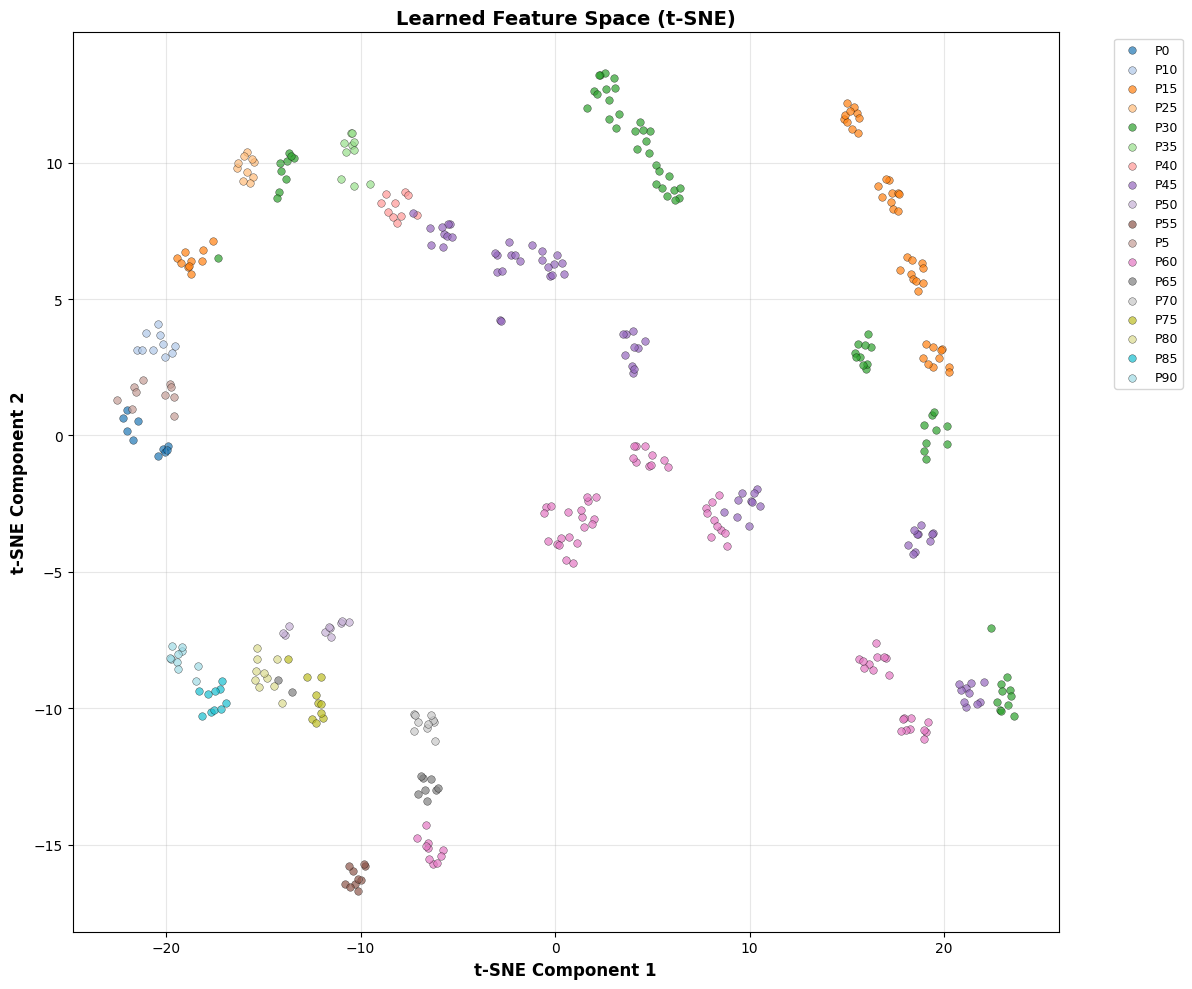

\n✅ t-SNE embedding visualization created
   This shows how the model organizes images in its learned feature space


In [94]:
# Extract learned features from the model
import numpy as np

print("Extracting learned feature embeddings...")

optimized_model.eval()
embeddings_list = []
pitch_labels_list = []
roll_labels_list = []

with torch.no_grad():
    for batch_idx, (images, (a)) in enumerate(test_loader):
        images = images.to(device)
        
        # Forward pass and get features before classification heads
        pitch_out, roll_out, features = optimized_model(images, return_features=True)
        
        embeddings_list.append(features.cpu().numpy())
        pitch_labels_list.append(a["pitch"].cpu().numpy())
        roll_labels_list.append(a["roll"].cpu().numpy())

# Concatenate all batches
embeddings = np.concatenate(embeddings_list, axis=0)
pitch_labels_all = np.concatenate(pitch_labels_list, axis=0)
roll_labels_all = np.concatenate(roll_labels_list, axis=0)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Number of samples: {len(embeddings)}")
print(f"Feature dimension: {embeddings.shape[1]}")

# Use plot_embedding_tsne utility
from src.utils import plot_embedding_tsne

plot_embedding_tsne(
    features=embeddings,
    labels=pitch_labels_all,
    label_names=pitch_names,
    save_path=project_root / 'reports' / '1_vanilla_cnn_tsne_embeddings.png',
    title='Learned Feature Space (t-SNE)'
)

print("\\n✅ t-SNE embedding visualization created")
print("   This shows how the model organizes images in its learned feature space")

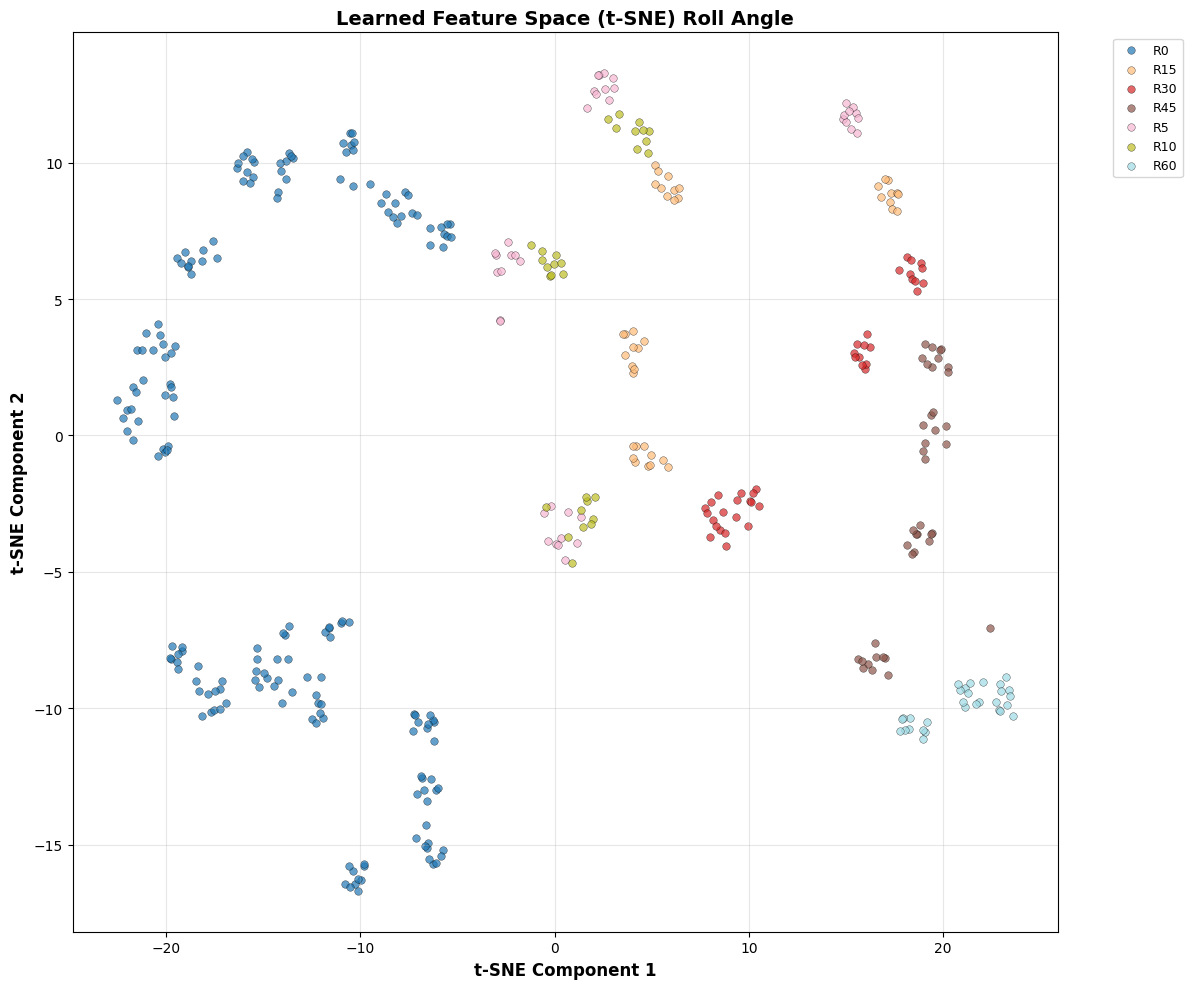

In [96]:
plot_embedding_tsne(
    features=embeddings,
    labels=roll_labels_all,
    label_names=roll_names,
    save_path=project_root / 'reports' / '1_vanilla_cnn_tsne_embeddings-roll.png',
    title='Learned Feature Space (t-SNE) Roll Angle'
)


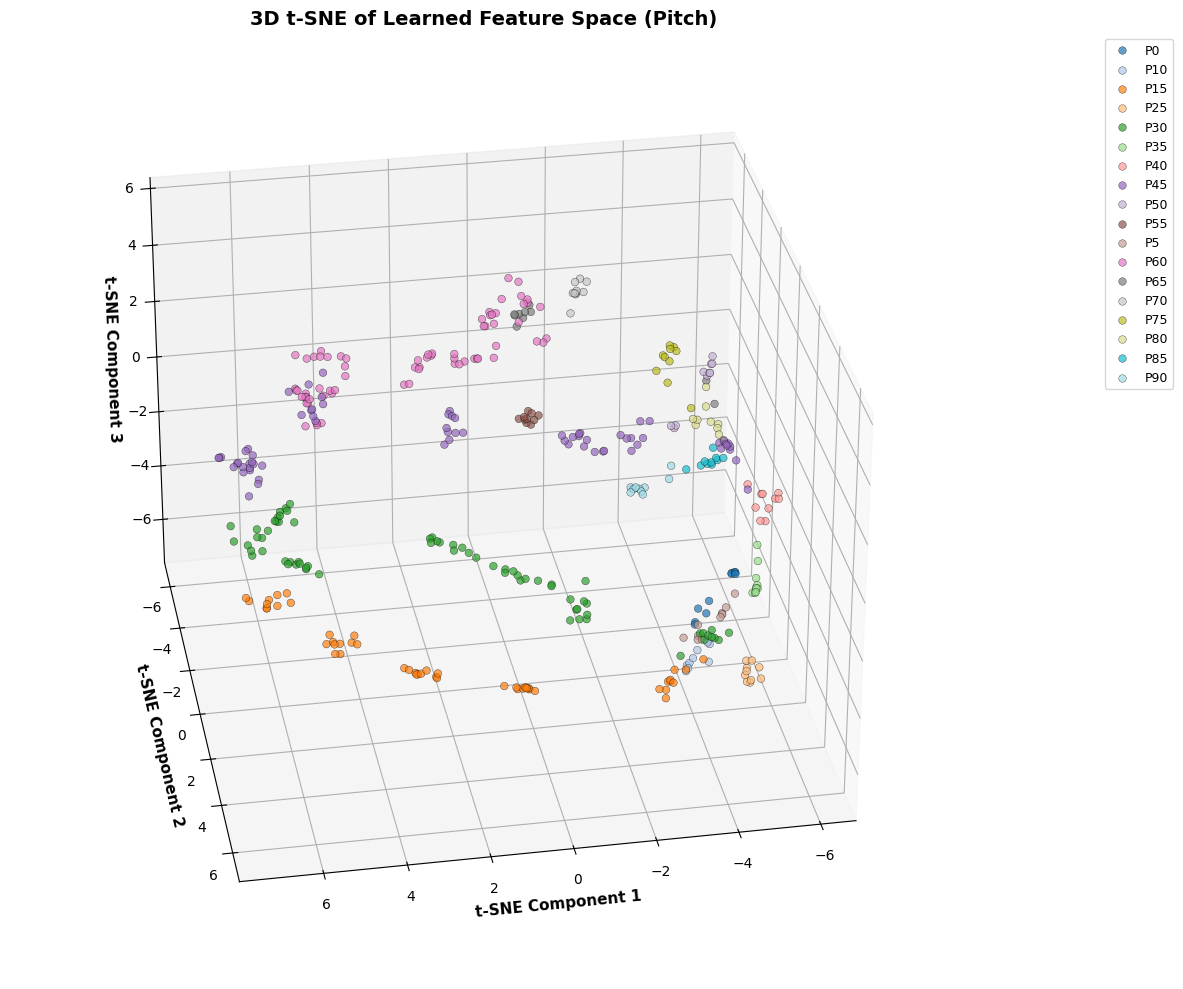

In [93]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # activates 3D projection
import numpy as np

# --- Compute 3D t-SNE ---
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
features_3d = tsne.fit_transform(embeddings)

# --- Plot ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

unique_pitch_labels_all = np.unique(pitch_labels_all)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_pitch_labels_all)))

for label, color in zip(unique_pitch_labels_all, colors):
    mask = pitch_labels_all == label
    ax.scatter(
        features_3d[mask, 0],
        features_3d[mask, 1],
        features_3d[mask, 2],
        c=[color],
        label=pitch_names[label] if label < len(pitch_names) else f'Class {label}',
        alpha=0.7,
        s=30,
        edgecolors='k',
        linewidth=0.3
    )

# --- Labels ---
ax.set_xlabel('t-SNE Component 1', fontweight='bold', fontsize=11)
ax.set_ylabel('t-SNE Component 2', fontweight='bold', fontsize=11)
ax.set_zlabel('t-SNE Component 3', fontweight='bold', fontsize=11)

ax.set_title('3D t-SNE of Learned Feature Space (Pitch)', fontsize=14, fontweight='bold')
ax.view_init(elev=30, azim=80)
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()

if project_root / 'reports' / '1_vanilla_cnn_tsne_3dembeddings.png':
    plt.savefig(project_root / 'reports' / '1_vanilla_cnn_tsne_3dembeddings.png', dpi=300, bbox_inches='tight')

plt.show()


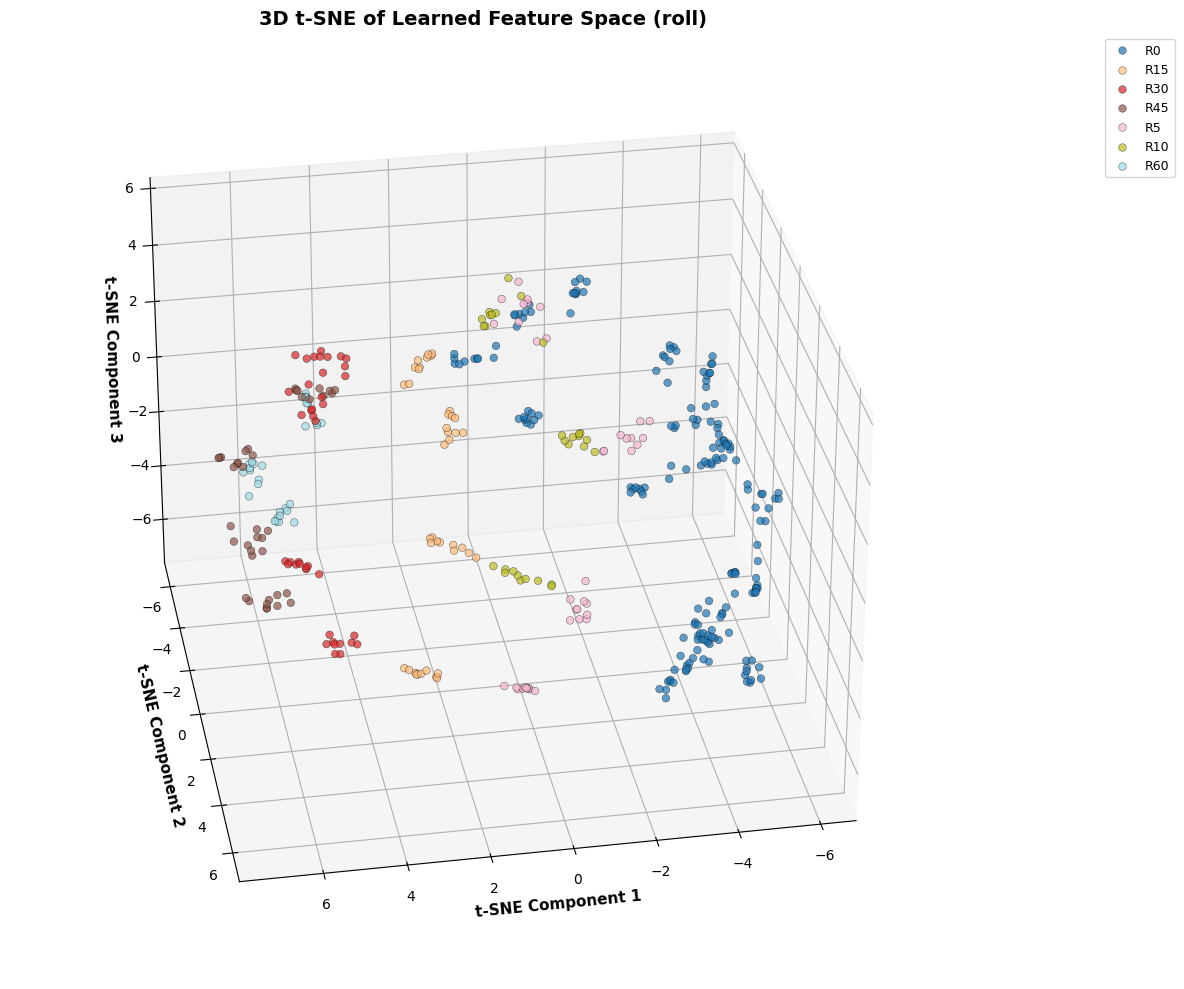

In [97]:

tsne = TSNE(n_components=3, random_state=42, perplexity=30)
features_3d = tsne.fit_transform(embeddings)

# --- Plot ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

unique_roll_labels_all = np.unique(roll_labels_all)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_roll_labels_all)))

for label, color in zip(unique_roll_labels_all, colors):
    mask = roll_labels_all == label
    ax.scatter(
        features_3d[mask, 0],
        features_3d[mask, 1],
        features_3d[mask, 2],
        c=[color],
        label=roll_names[label] if label < len(roll_names) else f'Class {label}',
        alpha=0.7,
        s=30,
        edgecolors='k',
        linewidth=0.3
    )

# --- Labels ---
ax.set_xlabel('t-SNE Component 1', fontweight='bold', fontsize=11)
ax.set_ylabel('t-SNE Component 2', fontweight='bold', fontsize=11)
ax.set_zlabel('t-SNE Component 3', fontweight='bold', fontsize=11)

ax.set_title('3D t-SNE of Learned Feature Space (roll)', fontsize=14, fontweight='bold')
ax.view_init(elev=30, azim=80)
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()

if project_root / 'reports' / '1_vanilla_cnn_tsne_3dembeddings.png':
    plt.savefig(project_root / 'reports' / '1_vanilla_cnn_tsne_3dembeddings-roll.png', dpi=300, bbox_inches='tight')

plt.show()

### 7.4 Feature Map Visualization

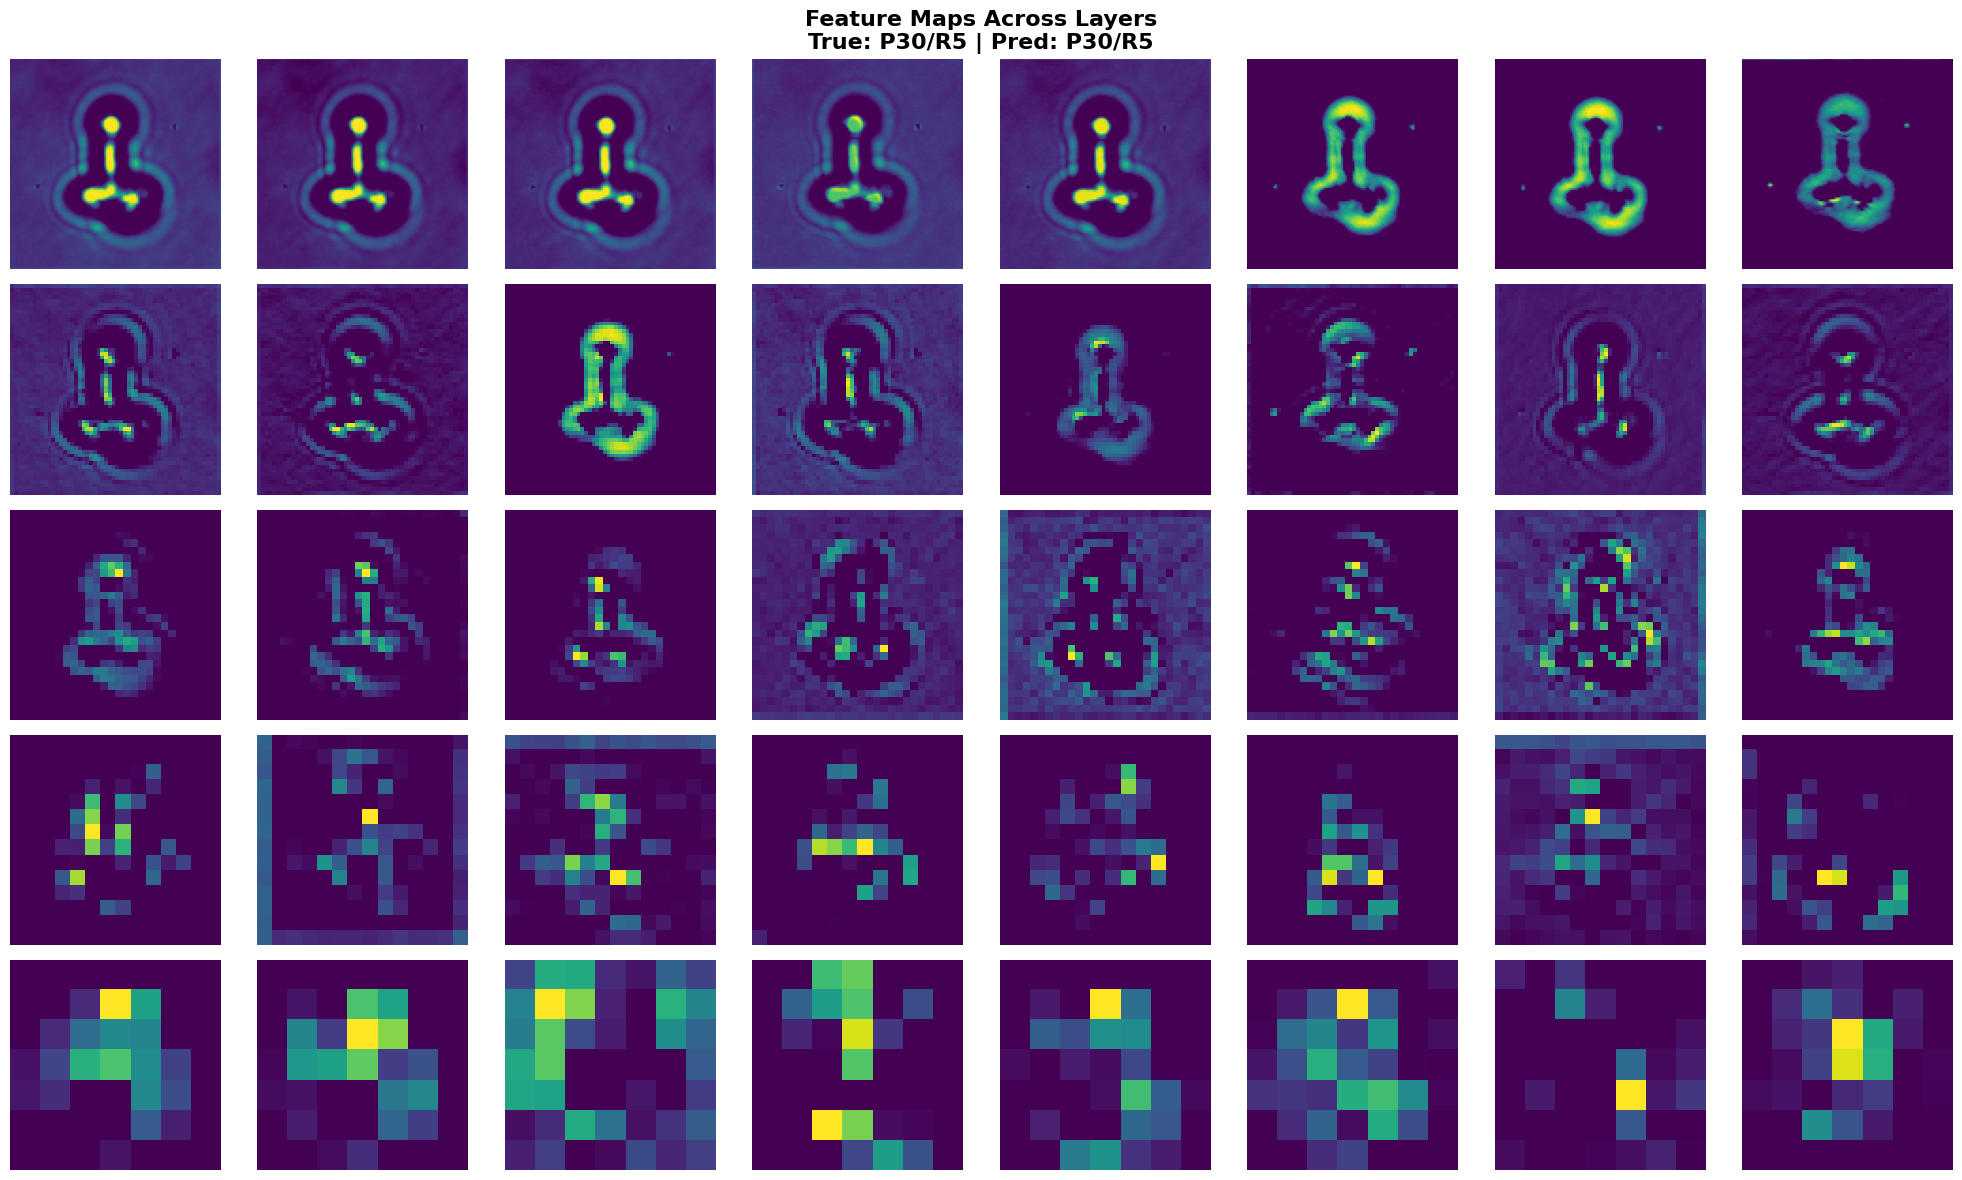

Feature maps visualized for sample 0
True labels: Pitch=P30, Roll=R5
Predictions: Pitch=P30, Roll=R5


In [37]:
# Get a sample image
sample_idx = 0
sample_img = test_predictions_opt['pitch_probs'][sample_idx:sample_idx+1]
sample_img_tensor = torch.from_numpy(sample_img).to(device)

# Get actual test sample for better visualization
actual_img, (pitch_label, roll_label) = test_dataset[test_idx[sample_idx]]
actual_img_tensor = actual_img.unsqueeze(0).to(device)

# Extract feature maps from each layer
optimized_model.eval()
activations = []

with torch.no_grad():
    x = actual_img_tensor  # Use actual image instead
    for i, block in enumerate(optimized_model.features):
        x = block(x)
        activations.append(x.cpu().numpy())

# Visualize feature maps from each layer
fig = plt.figure(figsize=(20, 12))
num_layers = len(activations)

for layer_idx in range(num_layers):
    activation = activations[layer_idx][0]  # First sample
    num_channels = min(8, activation.shape[0])  # Show max 8 channels
    
    for ch_idx in range(num_channels):
        ax = plt.subplot(num_layers, 8, layer_idx * 8 + ch_idx + 1)
        ax.imshow(activation[ch_idx], cmap='viridis')
        ax.axis('off')
        if ch_idx == 0:
            # Add layer info: channels and spatial size
            channels_total = activation.shape[0]
            spatial_size = f"{activation.shape[1]}x{activation.shape[2]}"
            ax.set_ylabel(
                f'Layer {layer_idx+1}\n({channels_total}ch, {spatial_size})', 
                fontweight='bold', 
                fontsize=9
            )

# Add title with sample info
true_pitch = pitch_names[test_predictions_opt['pitch_labels'][sample_idx]]
true_roll = roll_names[test_predictions_opt['roll_labels'][sample_idx]]
pred_pitch = pitch_names[test_predictions_opt['pitch_preds'][sample_idx]]
pred_roll = roll_names[test_predictions_opt['roll_preds'][sample_idx]]

plt.suptitle(
    f'Feature Maps Across Layers\nTrue: {true_pitch}/{true_roll} | Pred: {pred_pitch}/{pred_roll}', 
    fontsize=16, 
    fontweight='bold'
)
plt.tight_layout()
plt.savefig(project_root / 'reports' / '7_vanilla_cnn_depth_feature_maps.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Feature maps visualized for sample {sample_idx}")
print(f"True labels: Pitch={true_pitch}, Roll={true_roll}")
print(f"Predictions: Pitch={pred_pitch}, Roll={pred_roll}")